<a href="https://colab.research.google.com/github/cardstdani/practica-par/blob/main/PracticaParadigmas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Práctica Paradigmas 1**

In [2]:
!pip install pyvis==0.3.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Error al cargar el fichero tablero, usando tablero aleatorio...
Error al cargar el fichero secuencia, usando secuencia aleatoria...
Que empiece el juego:😉


,0,1,2,3,4,5,6,7,8,9
A,1,.,b,.,.,.,a,.,c,a
B,b,.,.,a,.,a,.,.,.,.
C,.,c,.,.,.,.,.,a,.,.
D,.,a,.,.,.,.,.,.,.,.
E,a,.,.,b,.,.,a,.,.,a
F,a,.,.,.,.,.,.,.,.,.
G,.,.,.,b,1,.,a,.,c,.
H,a,.,a,a,.,.,.,.,.,.
I,.,a,.,.,.,1,a,a,.,.
J,a,a,.,1,.,.,.,a,b,.



Turno: 0 Puntos:20
Almacen: [.] Actual: [a]


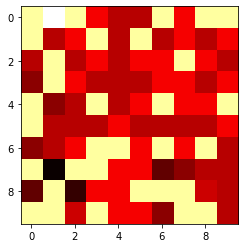

,0,1,2,3,4,5,6,7,8,9
A,2,a,b,.,.,.,a,.,c,a
B,b,.,.,a,.,a,.,.,.,.
C,.,c,.,.,.,.,.,a,.,.
D,.,a,.,.,.,.,.,.,.,.
E,a,.,.,b,.,.,a,.,.,a
F,a,.,.,.,.,.,.,.,.,.
G,.,.,.,b,1,.,a,.,c,.
H,a,.,a,a,.,.,.,.,.,.
I,.,a,.,.,.,1,a,a,.,.
J,a,a,.,1,.,.,.,a,b,.



Turno: 1 Puntos:41
Almacen: [.] Actual: [a]


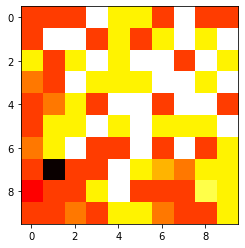

,0,1,2,3,4,5,6,7,8,9
A,2,a,b,a,.,.,a,.,c,a
B,b,.,.,a,.,a,.,.,.,.
C,.,c,.,.,.,.,.,a,.,.
D,.,a,.,.,.,.,.,.,.,.
E,a,.,.,b,.,.,a,.,.,a
F,a,.,.,.,1,.,.,.,.,.
G,.,.,.,b,.,.,a,.,c,.
H,a,.,a,a,.,1,.,.,.,.
I,.,a,.,1,.,.,a,a,.,.
J,a,a,.,.,.,.,.,a,b,.



Turno: 2 Puntos:42
Almacen: [.] Actual: [a]


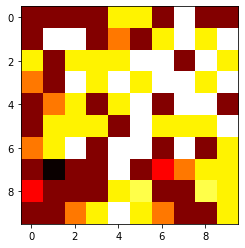

,0,1,2,3,4,5,6,7,8,9
A,2,a,b,a,.,.,a,a,c,a
B,b,.,.,a,.,a,.,.,.,.
C,.,c,.,.,.,.,.,a,.,.
D,.,a,.,.,.,.,.,.,.,.
E,a,.,.,b,1,.,a,.,.,a
F,a,.,.,.,.,.,.,.,.,.
G,.,.,.,b,.,1,a,.,c,.
H,a,.,a,a,.,.,.,.,.,.
I,.,a,.,.,1,.,a,a,.,.
J,a,a,.,.,.,.,.,a,b,.



Turno: 3 Puntos:43
Almacen: [.] Actual: [a]


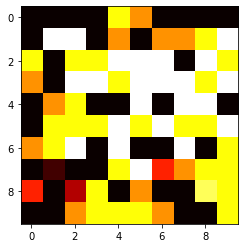

,0,1,2,3,4,5,6,7,8,9
A,2,a,b,a,.,.,a,a,c,a
B,b,a,.,a,.,a,.,.,.,.
C,.,c,.,.,.,.,.,a,.,.
D,.,a,.,.,1,.,.,.,.,.
E,a,.,.,b,.,.,a,.,.,a
F,a,.,.,.,.,1,.,.,.,.
G,.,.,.,b,.,.,a,.,c,.
H,a,.,a,a,1,.,.,.,.,.
I,.,a,.,.,.,.,a,a,.,.
J,a,a,.,.,.,.,.,a,b,.



Turno: 4 Puntos:44
Almacen: [.] Actual: [b]


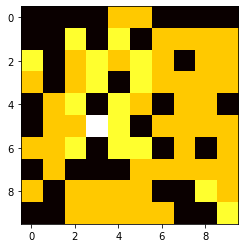

,0,1,2,3,4,5,6,7,8,9
A,2,a,b,a,.,.,a,a,c,a
B,b,a,.,a,.,a,.,.,.,.
C,.,c,.,.,1,.,.,a,.,.
D,.,a,.,.,.,.,.,.,.,.
E,a,.,.,.,.,1,a,.,.,a
F,a,.,.,c,.,.,.,.,.,.
G,.,.,.,.,1,.,a,.,c,.
H,a,.,a,a,.,.,.,.,.,.
I,.,a,.,.,.,.,a,a,.,.
J,a,a,.,.,.,.,.,a,b,.



Turno: 5 Puntos:59
Almacen: [.] Actual: [1]


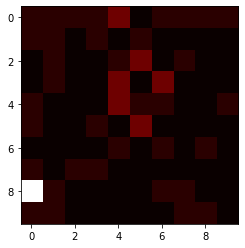

,0,1,2,3,4,5,6,7,8,9
A,2,a,b,a,.,.,a,a,c,a
B,b,a,.,a,1,a,.,.,.,.
C,.,c,.,.,.,.,.,a,.,.
D,.,a,.,.,.,1,.,.,.,.
E,a,.,.,.,.,.,a,.,.,a
F,a,.,.,c,1,.,.,.,.,.
G,.,.,.,.,.,.,a,.,c,.
H,a,.,a,a,.,.,.,.,.,.
I,2,a,.,.,.,.,a,a,.,.
J,a,a,.,.,.,.,.,a,b,.



Turno: 6 Puntos:54
Almacen: [.] Actual: [a]


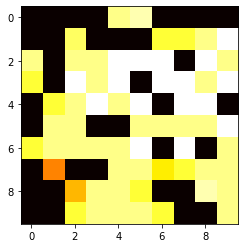

,0,1,2,3,4,5,6,7,8,9
A,2,a,b,a,1,.,a,a,c,a
B,b,a,.,a,.,a,.,.,.,a
C,.,c,.,.,.,1,.,a,.,.
D,.,a,.,.,.,.,.,.,.,.
E,a,.,.,.,1,.,a,.,.,a
F,a,.,.,c,.,.,.,.,.,.
G,.,.,.,.,.,.,a,.,c,.
H,a,.,a,a,.,.,.,.,.,.
I,2,a,.,.,.,.,a,a,.,.
J,a,a,.,.,.,.,.,a,b,.



Turno: 7 Puntos:55
Almacen: [.] Actual: [b]


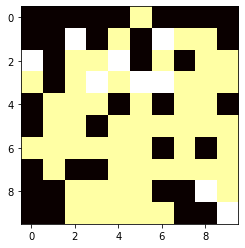

,0,1,2,3,4,5,6,7,8,9
A,2,a,b,a,.,1,a,a,c,a
B,b,a,b,a,.,a,.,.,.,a
C,.,c,.,.,.,.,1,a,.,.
D,.,a,.,.,1,.,.,.,.,.
E,a,.,.,.,.,.,a,.,.,a
F,a,.,.,c,.,.,.,.,.,.
G,.,.,.,.,.,.,a,.,c,.
H,a,.,a,a,.,.,.,.,.,.
I,2,a,.,.,.,.,a,a,.,.
J,a,a,.,.,.,.,.,a,b,.



Turno: 8 Puntos:60
Almacen: [.] Actual: [b]


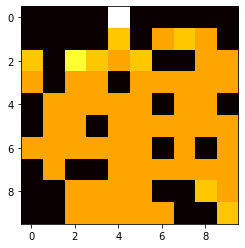

,0,1,2,3,4,5,6,7,8,9
A,2,a,b,a,b,2,a,a,c,a
B,b,a,b,a,.,a,1,.,.,a
C,.,c,.,.,1,.,.,a,.,.
D,.,a,.,.,.,.,.,.,.,.
E,a,.,.,.,.,.,a,.,.,a
F,a,.,.,c,.,.,.,.,.,.
G,.,.,.,.,.,.,a,.,c,.
H,a,.,a,a,.,.,.,.,.,.
I,2,a,.,.,.,.,a,a,.,.
J,a,a,.,.,.,.,.,a,b,.



Turno: 9 Puntos:85
Almacen: [.] Actual: [a]


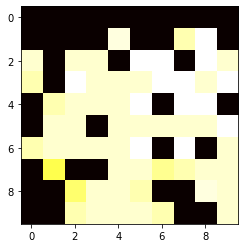

,0,1,2,3,4,5,6,7,8,9
A,2,a,b,a,b,2,a,a,c,.
B,b,a,b,a,1,a,.,1,b,.
C,.,c,.,.,.,.,.,a,.,.
D,.,a,.,.,.,.,.,.,.,.
E,a,.,.,.,.,.,a,.,.,a
F,a,.,.,c,.,.,.,.,.,.
G,.,.,.,.,.,.,a,.,c,.
H,a,.,a,a,.,.,.,.,.,.
I,2,a,.,.,.,.,a,a,.,.
J,a,a,.,.,.,.,.,a,b,.



Turno: 10 Puntos:88
Almacen: [.] Actual: [c]


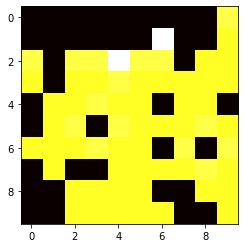

,0,1,2,3,4,5,6,7,8,9
A,2,a,b,a,b,2,a,a,c,.
B,b,a,b,a,.,a,c,2,b,.
C,.,c,.,.,1,.,.,a,.,.
D,.,a,.,.,.,.,.,.,.,.
E,a,.,.,.,.,.,a,.,.,a
F,a,.,.,c,.,.,.,.,.,.
G,.,.,.,.,.,.,a,.,c,.
H,a,.,a,a,.,.,.,.,.,.
I,2,a,.,.,.,.,a,a,.,.
J,a,a,.,.,.,.,.,a,b,.



Turno: 11 Puntos:133
Almacen: [.] Actual: [c]


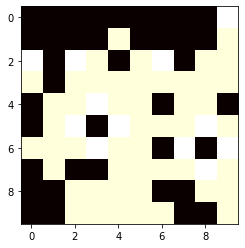

,0,1,2,3,4,5,6,7,8,9
A,2,a,b,a,b,2,a,a,c,c
B,b,a,b,a,1,a,c,2,b,.
C,.,c,.,.,x,.,.,a,.,.
D,.,a,.,.,.,.,.,.,.,.
E,a,.,.,.,.,.,a,.,.,a
F,a,.,.,c,.,.,.,.,.,.
G,.,.,.,.,.,.,a,.,c,.
H,a,.,a,a,.,.,.,.,.,.
I,2,a,.,.,.,.,a,a,.,.
J,a,a,.,.,.,.,.,a,b,.



Turno: 12 Puntos:108
Almacen: [.] Actual: [a]


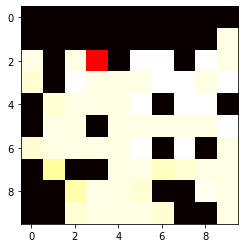

,0,1,2,3,4,5,6,7,8,9
A,2,a,b,a,b,2,a,a,c,c
B,b,a,b,a,2,a,c,2,b,.
C,.,c,.,.,x,a,.,a,.,.
D,.,a,.,.,.,.,.,.,.,.
E,a,.,.,.,.,.,a,.,.,a
F,a,.,.,c,.,.,.,.,.,.
G,.,.,.,.,.,.,a,.,c,.
H,a,.,a,a,.,.,.,.,.,.
I,2,a,.,.,.,.,a,a,.,.
J,a,a,.,.,.,.,.,a,b,.



Turno: 13 Puntos:129
Almacen: [.] Actual: [a]


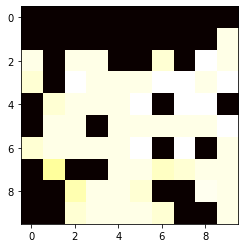

,0,1,2,3,4,5,6,7,8,9
A,2,a,b,a,b,2,a,a,c,c
B,b,a,b,a,2,a,c,2,b,.
C,.,c,.,.,x,a,.,a,a,.
D,.,a,.,.,.,.,.,.,.,.
E,a,.,.,.,.,.,a,.,.,a
F,a,.,.,c,.,.,.,.,.,.
G,.,.,.,.,.,.,a,.,c,.
H,a,.,a,a,.,.,.,.,.,.
I,2,a,.,.,.,.,a,a,.,.
J,a,a,.,.,.,.,.,a,b,.



Turno: 14 Puntos:130
Almacen: [.] Actual: [w]


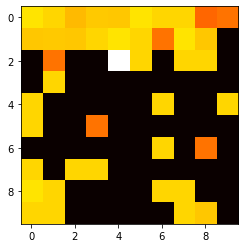

,0,1,2,3,4,5,6,7,8,9
A,2,a,b,a,b,2,a,a,c,c
B,b,a,b,a,2,a,c,2,b,.
C,.,c,.,.,.,a,.,a,a,.
D,.,a,.,.,.,.,.,.,.,.
E,a,.,.,.,.,.,a,.,.,a
F,a,.,.,c,.,.,.,.,.,.
G,.,.,.,.,.,.,a,.,c,.
H,a,.,a,a,.,.,.,.,.,.
I,2,a,.,.,.,.,a,a,.,.
J,a,a,.,.,.,.,.,a,b,.



Turno: 15 Puntos:180
Almacen: [.] Actual: [a]


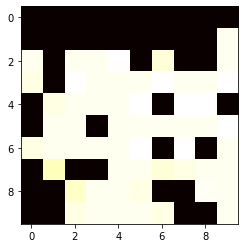

,0,1,2,3,4,5,6,7,8,9
A,2,a,b,a,b,2,a,a,c,c
B,b,a,b,a,2,.,c,2,b,.
C,.,c,.,.,b,.,.,a,a,.
D,.,a,.,.,.,.,.,.,.,.
E,a,.,.,.,.,.,a,.,.,a
F,a,.,.,c,.,.,.,.,.,.
G,.,.,.,.,.,.,a,.,c,.
H,a,.,a,a,.,.,.,.,.,.
I,2,a,.,.,.,.,a,a,.,.
J,a,a,.,.,.,.,.,a,b,.



Turno: 16 Puntos:183
Almacen: [.] Actual: [b]


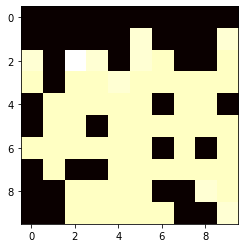

,0,1,2,3,4,5,6,7,8,9
A,2,a,.,a,b,2,a,a,c,c
B,b,a,.,a,2,.,c,2,b,.
C,.,c,c,.,b,.,.,a,a,.
D,.,a,.,.,.,.,.,.,.,.
E,a,.,.,.,.,.,a,.,.,a
F,a,.,.,c,.,.,.,.,.,.
G,.,.,.,.,.,.,a,.,c,.
H,a,.,a,a,.,.,.,.,.,.
I,2,a,.,.,.,.,a,a,.,.
J,a,a,.,.,.,.,.,a,b,.



Turno: 17 Puntos:198
Almacen: [.] Actual: [a]


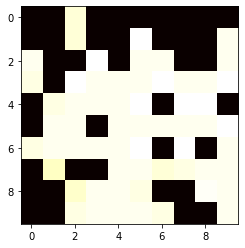

,0,1,2,3,4,5,6,7,8,9
A,2,a,.,a,b,2,a,a,c,c
B,b,a,.,a,2,a,c,2,b,.
C,.,c,c,.,b,.,.,a,a,.
D,.,a,.,.,.,.,.,.,.,.
E,a,.,.,.,.,.,a,.,.,a
F,a,.,.,c,.,.,.,.,.,.
G,.,.,.,.,.,.,a,.,c,.
H,a,.,a,a,.,.,.,.,.,.
I,2,a,.,.,.,.,a,a,.,.
J,a,a,.,.,.,.,.,a,b,.



Turno: 18 Puntos:199
Almacen: [.] Actual: [c]


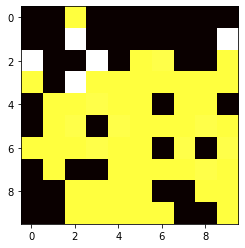

,0,1,2,3,4,5,6,7,8,9
A,2,a,.,a,b,2,a,a,c,c
B,b,a,d,a,2,a,c,2,b,.
C,.,.,.,.,b,.,.,a,a,.
D,.,a,.,.,.,.,.,.,.,.
E,a,.,.,.,.,.,a,.,.,a
F,a,.,.,c,.,.,.,.,.,.
G,.,.,.,.,.,.,a,.,c,.
H,a,.,a,a,.,.,.,.,.,.
I,2,a,.,.,.,.,a,a,.,.
J,a,a,.,.,.,.,.,a,b,.



Turno: 19 Puntos:274
Almacen: [.] Actual: [1]


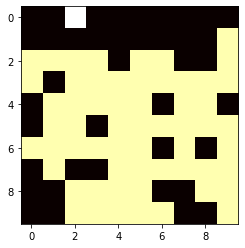

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,c,c
B,b,a,d,a,2,a,c,2,b,.
C,.,.,.,.,b,.,.,a,a,.
D,.,a,.,.,.,.,.,.,.,.
E,a,.,.,.,.,.,a,.,.,a
F,a,.,.,c,.,.,.,.,.,.
G,.,.,.,.,.,.,a,.,c,.
H,a,.,a,a,.,.,.,.,.,.
I,2,a,.,.,.,.,a,a,.,.
J,a,a,.,.,.,.,.,a,b,.



Turno: 20 Puntos:269
Almacen: [.] Actual: [a]


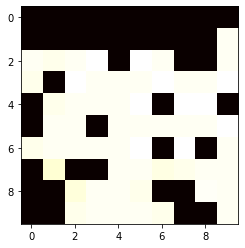

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,.,b,2,a,a,c,c
B,b,a,d,.,2,a,c,2,b,.
C,.,.,.,b,b,.,.,a,a,.
D,.,a,.,.,.,.,.,.,.,.
E,a,.,.,.,.,.,a,.,.,a
F,a,.,.,c,.,.,.,.,.,.
G,.,.,.,.,.,.,a,.,c,.
H,a,.,a,a,.,.,.,.,.,.
I,2,a,.,.,.,.,a,a,.,.
J,a,a,.,.,.,.,.,a,b,.



Turno: 21 Puntos:272
Almacen: [.] Actual: [a]


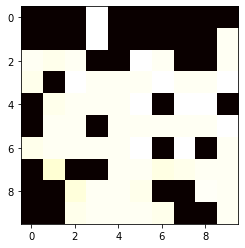

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,c,c
B,b,a,d,.,2,a,c,2,b,.
C,.,.,.,b,b,.,.,a,a,.
D,.,a,.,.,.,.,.,.,.,.
E,a,.,.,.,.,.,a,.,.,a
F,a,.,.,c,.,.,.,.,.,.
G,.,.,.,.,.,.,a,.,c,.
H,a,.,a,a,.,.,.,.,.,.
I,2,a,.,.,.,.,a,a,.,.
J,a,a,.,.,.,.,.,a,b,.



Turno: 22 Puntos:273
Almacen: [.] Actual: [1]


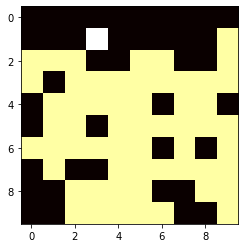

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,c,c
B,b,a,d,2,2,a,c,2,b,.
C,.,.,.,b,b,.,.,a,a,.
D,.,a,.,.,.,.,.,.,.,.
E,a,.,.,.,.,.,a,.,.,a
F,a,.,.,c,.,.,.,.,.,.
G,.,.,.,.,.,.,a,.,c,.
H,a,.,a,a,.,.,.,.,.,.
I,2,a,.,.,.,.,a,a,.,.
J,a,a,.,.,.,.,.,a,b,.



Turno: 23 Puntos:268
Almacen: [.] Actual: [a]


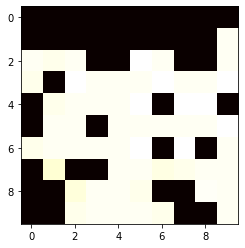

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,c,c
B,b,a,d,2,2,a,c,2,b,.
C,.,.,.,b,b,a,.,a,a,.
D,.,a,.,.,.,.,.,.,.,.
E,a,.,.,.,.,.,a,.,.,a
F,a,.,.,c,.,.,.,.,.,.
G,.,.,.,.,.,.,a,.,c,.
H,a,.,a,a,.,.,.,.,.,.
I,2,a,.,.,.,.,a,a,.,.
J,a,a,.,.,.,.,.,a,b,.



Turno: 24 Puntos:269
Almacen: [.] Actual: [c]


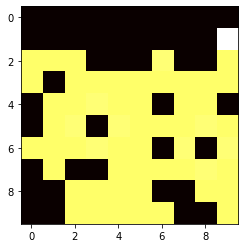

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,.,.
B,b,a,d,2,2,a,c,2,b,d
C,.,.,.,b,b,a,.,a,a,.
D,.,a,.,.,.,.,.,.,.,.
E,a,.,.,.,.,.,a,.,.,a
F,a,.,.,c,.,.,.,.,.,.
G,.,.,.,.,.,.,a,.,c,.
H,a,.,a,a,.,.,.,.,.,.
I,2,a,.,.,.,.,a,a,.,.
J,a,a,.,.,.,.,.,a,b,.



Turno: 25 Puntos:344
Almacen: [.] Actual: [1]


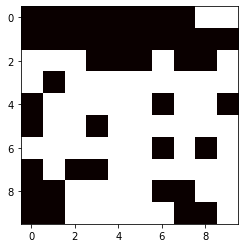

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,1,.
B,b,a,d,2,2,a,c,2,b,d
C,.,.,.,b,b,a,.,a,a,.
D,.,a,.,.,.,.,.,.,.,.
E,a,.,.,.,.,.,a,.,.,a
F,a,.,.,c,.,.,.,.,.,.
G,.,.,.,.,.,.,a,.,c,.
H,a,.,a,a,.,.,.,.,.,.
I,2,a,.,.,.,.,a,a,.,.
J,a,a,.,.,.,.,.,a,b,.



Turno: 26 Puntos:319
Almacen: [.] Actual: [a]


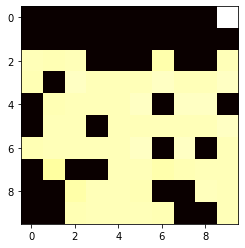

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,.,.,.,b,b,a,.,a,a,.
D,.,a,.,.,.,.,.,.,.,.
E,a,.,.,.,.,.,a,.,.,a
F,a,.,.,c,.,.,.,.,.,.
G,.,.,.,.,.,.,a,.,c,.
H,a,.,a,a,.,.,.,.,.,.
I,2,a,.,.,.,.,a,a,.,.
J,a,a,.,.,.,.,.,a,b,.



Turno: 27 Puntos:340
Almacen: [.] Actual: [a]


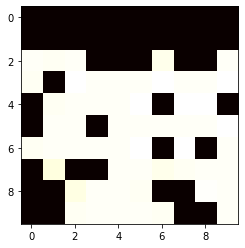

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,.,.,.,b,b,a,.,a,a,.
D,.,a,a,.,.,.,.,.,.,.
E,a,.,.,.,.,.,a,.,.,a
F,a,.,.,c,.,.,.,.,.,.
G,.,.,.,.,.,.,a,.,c,.
H,a,.,a,a,.,.,.,.,.,.
I,2,a,.,.,.,.,a,a,.,.
J,a,a,.,.,.,.,.,a,b,.



Turno: 28 Puntos:341
Almacen: [.] Actual: [b]


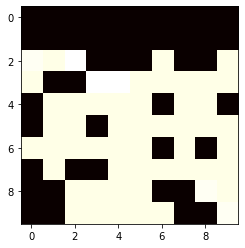

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,.,.,c,.,.,a,.,a,a,.
D,.,a,a,.,.,.,.,.,.,.
E,a,.,.,.,.,.,a,.,.,a
F,a,.,.,c,.,.,.,.,.,.
G,.,.,.,.,.,.,a,.,c,.
H,a,.,a,a,.,.,.,.,.,.
I,2,a,.,.,.,.,a,a,.,.
J,a,a,.,.,.,.,.,a,b,.



Turno: 29 Puntos:356
Almacen: [.] Actual: [a]


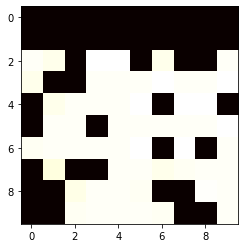

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,.,.,c,a,.,a,.,a,a,.
D,.,a,a,.,.,.,.,.,.,.
E,a,.,.,.,.,.,a,.,.,a
F,a,.,.,c,.,.,.,.,.,.
G,.,.,.,.,.,.,a,.,c,.
H,a,.,a,a,.,.,.,.,.,.
I,2,a,.,.,.,.,a,a,.,.
J,a,a,.,.,.,.,.,a,b,.



Turno: 30 Puntos:357
Almacen: [.] Actual: [a]


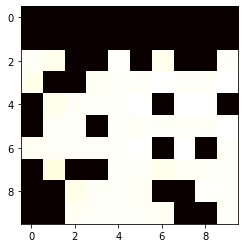

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,.,.,c,a,.,a,.,a,a,.
D,.,a,a,.,.,.,a,.,.,.
E,a,.,.,.,.,.,a,.,.,a
F,a,.,.,c,.,.,.,.,.,.
G,.,.,.,.,.,.,a,.,c,.
H,a,.,a,a,.,.,.,.,.,.
I,2,a,.,.,.,.,a,a,.,.
J,a,a,.,.,.,.,.,a,b,.



Turno: 31 Puntos:358
Almacen: [.] Actual: [a]


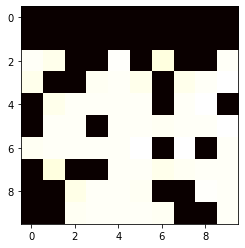

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,.,.,c,a,.,a,.,a,a,.
D,.,a,a,.,.,.,a,.,.,a
E,a,.,.,.,.,.,a,.,.,a
F,a,.,.,c,.,.,.,.,.,.
G,.,.,.,.,.,.,a,.,c,.
H,a,.,a,a,.,.,.,.,.,.
I,2,a,.,.,.,.,a,a,.,.
J,a,a,.,.,.,.,.,a,b,.



Turno: 32 Puntos:359
Almacen: [.] Actual: [a]


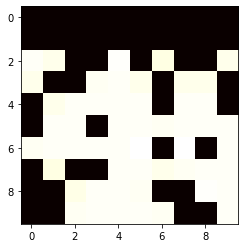

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,.,.,c,a,.,a,.,a,a,.
D,.,a,a,.,.,.,a,.,.,a
E,a,.,.,.,.,.,a,.,.,a
F,a,.,.,c,.,.,.,.,.,.
G,.,.,.,.,.,a,a,.,c,.
H,a,.,a,a,.,.,.,.,.,.
I,2,a,.,.,.,.,a,a,.,.
J,a,a,.,.,.,.,.,a,b,.



Turno: 33 Puntos:360
Almacen: [.] Actual: [a]


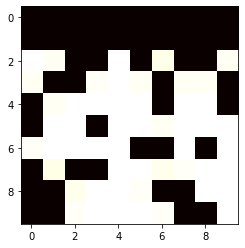

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,.,c,2,b,d
C,.,.,c,.,b,.,.,a,a,.
D,.,a,a,.,.,.,a,.,.,a
E,a,.,.,.,.,.,a,.,.,a
F,a,.,.,c,.,.,.,.,.,.
G,.,.,.,.,.,a,a,.,c,.
H,a,.,a,a,.,.,.,.,.,.
I,2,a,.,.,.,.,a,a,.,.
J,a,a,.,.,.,.,.,a,b,.



Turno: 34 Puntos:362
Almacen: [.] Actual: [a]


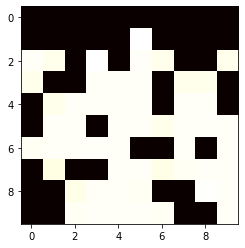

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,.,.,c,.,b,.,.,a,a,.
D,.,a,a,.,.,.,a,.,.,a
E,a,.,.,.,.,.,a,.,.,a
F,a,.,.,c,.,.,.,.,.,.
G,.,.,.,.,.,a,a,.,c,.
H,a,.,a,a,.,.,.,.,.,.
I,2,a,.,.,.,.,a,a,.,.
J,a,a,.,.,.,.,.,a,b,.



Turno: 35 Puntos:363
Almacen: [.] Actual: [a]


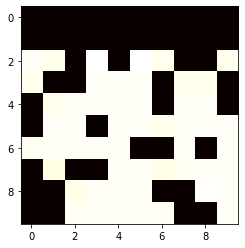

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,.,.,c,a,b,.,.,a,a,.
D,.,a,a,.,.,.,a,.,.,a
E,a,.,.,.,.,.,a,.,.,a
F,a,.,.,c,.,.,.,.,.,.
G,.,.,.,.,.,a,a,.,c,.
H,a,.,a,a,.,.,.,.,.,.
I,2,a,.,.,.,.,a,a,.,.
J,a,a,.,.,.,.,.,a,b,.



Turno: 36 Puntos:364
Almacen: [.] Actual: [a]


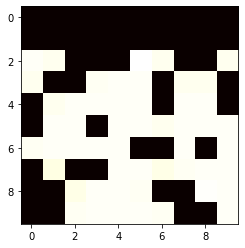

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,.,.,c,a,b,a,.,a,a,.
D,.,a,a,.,.,.,a,.,.,a
E,a,.,.,.,.,.,a,.,.,a
F,a,.,.,c,.,.,.,.,.,.
G,.,.,.,.,.,a,a,.,c,.
H,a,.,a,a,.,.,.,.,.,.
I,2,a,.,.,.,.,a,a,.,.
J,a,a,.,.,.,.,.,a,b,.



Turno: 37 Puntos:365
Almacen: [.] Actual: [1]


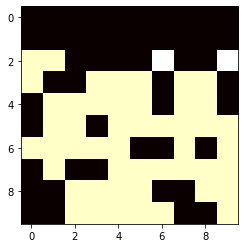

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,.,.,c,a,b,a,2,a,a,.
D,.,a,a,.,.,.,a,.,.,a
E,a,.,.,.,.,.,a,.,.,a
F,a,.,.,c,.,.,.,.,.,.
G,.,.,.,.,.,a,a,.,c,.
H,a,.,a,a,.,.,.,.,.,.
I,2,a,.,.,.,.,a,a,.,.
J,a,a,.,.,.,.,.,a,b,.



Turno: 38 Puntos:360
Almacen: [.] Actual: [a]


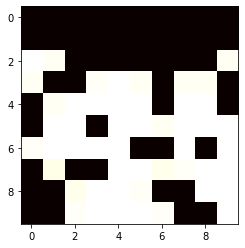

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,.,.,c,a,b,a,2,a,a,.
D,.,a,a,.,.,.,a,.,.,a
E,a,.,.,.,.,.,a,.,.,a
F,a,.,.,c,.,.,.,.,.,.
G,.,.,.,.,.,a,a,.,c,.
H,a,.,a,a,.,.,.,.,.,.
I,2,a,.,.,.,.,.,.,b,.
J,a,a,.,.,.,.,.,.,b,.



Turno: 39 Puntos:362
Almacen: [.] Actual: [1]


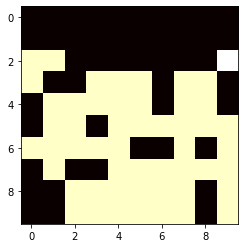

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,.,.,c,a,b,a,2,a,a,2
D,.,a,a,.,.,.,a,.,.,a
E,a,.,.,.,.,.,a,.,.,a
F,a,.,.,c,.,.,.,.,.,.
G,.,.,.,.,.,a,a,.,c,.
H,a,.,a,a,.,.,.,.,.,.
I,2,a,.,.,.,.,.,.,b,.
J,a,a,.,.,.,.,.,.,b,.



Turno: 40 Puntos:357
Almacen: [.] Actual: [a]


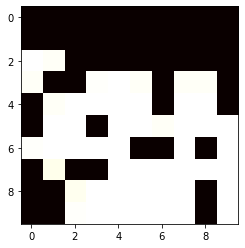

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,.,c,a,b,a,2,a,a,2
D,.,a,a,.,.,.,a,.,.,a
E,a,.,.,.,.,.,a,.,.,a
F,a,.,.,c,.,.,.,.,.,.
G,.,.,.,.,.,a,a,.,c,.
H,a,.,a,a,.,.,.,.,.,.
I,2,a,.,.,.,.,.,.,b,.
J,a,a,.,.,.,.,.,.,b,.



Turno: 41 Puntos:358
Almacen: [.] Actual: [a]


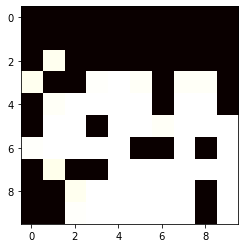

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,.,c,a,b,a,2,a,a,2
D,.,a,a,.,a,.,a,.,.,a
E,a,.,.,.,.,.,a,.,.,a
F,a,.,.,c,.,.,.,.,.,.
G,.,.,.,.,.,a,a,.,c,.
H,a,.,a,a,.,.,.,.,.,.
I,2,a,.,.,.,.,.,.,b,.
J,a,a,.,.,.,.,.,.,b,.



Turno: 42 Puntos:359
Almacen: [.] Actual: [a]


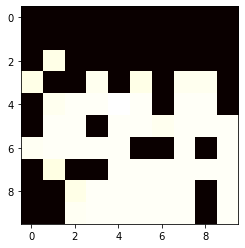

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,.,c,a,b,a,2,a,a,2
D,.,a,a,.,a,.,a,.,.,a
E,a,.,.,.,a,.,a,.,.,a
F,a,.,.,c,.,.,.,.,.,.
G,.,.,.,.,.,a,a,.,c,.
H,a,.,a,a,.,.,.,.,.,.
I,2,a,.,.,.,.,.,.,b,.
J,a,a,.,.,.,.,.,.,b,.



Turno: 43 Puntos:360
Almacen: [.] Actual: [a]


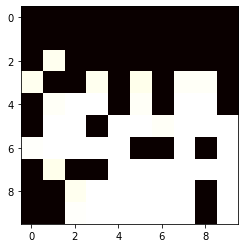

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,.,c,a,b,a,2,a,a,2
D,.,.,.,.,a,.,a,.,.,a
E,a,.,b,.,a,.,a,.,.,a
F,a,.,.,c,.,.,.,.,.,.
G,.,.,.,.,.,a,a,.,c,.
H,a,.,a,a,.,.,.,.,.,.
I,2,a,.,.,.,.,.,.,b,.
J,a,a,.,.,.,.,.,.,b,.



Turno: 44 Puntos:363
Almacen: [.] Actual: [a]


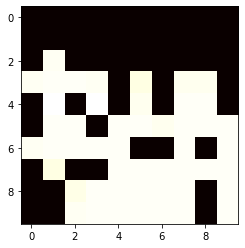

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,.,c,a,b,a,2,a,a,2
D,.,.,.,.,a,.,a,.,.,a
E,.,b,b,.,a,.,a,.,.,a
F,.,.,.,c,.,.,.,.,.,.
G,.,.,.,.,.,a,a,.,c,.
H,a,.,a,a,.,.,.,.,.,.
I,2,a,.,.,.,.,.,.,b,.
J,a,a,.,.,.,.,.,.,b,.



Turno: 45 Puntos:366
Almacen: [.] Actual: [w]


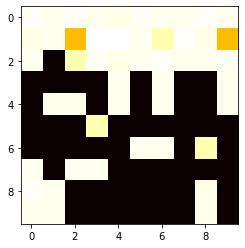

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,.,2,a,c,2,b,d
C,a,.,c,a,b,a,2,a,a,2
D,.,.,.,.,a,.,a,.,.,a
E,.,b,b,.,a,.,a,.,.,a
F,.,.,.,c,.,.,.,.,.,.
G,.,.,.,.,.,a,a,.,c,.
H,a,.,a,a,.,.,.,.,.,.
I,2,a,.,.,.,.,.,.,b,.
J,a,a,.,.,.,.,.,.,b,.



Turno: 46 Puntos:371
Almacen: [.] Actual: [1]


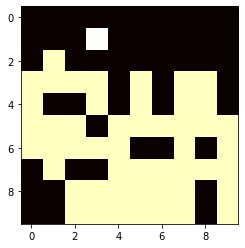

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,.,c,a,b,a,2,a,a,2
D,.,.,.,.,a,.,a,.,.,a
E,.,b,b,.,a,.,a,.,.,a
F,.,.,.,c,.,.,.,.,.,.
G,.,.,.,.,.,a,a,.,c,.
H,a,.,a,a,.,.,.,.,.,.
I,2,a,.,.,.,.,.,.,b,.
J,a,a,.,.,.,.,.,.,b,.



Turno: 47 Puntos:366
Almacen: [.] Actual: [b]


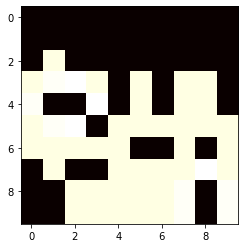

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,.,c,a,b,a,2,a,a,2
D,.,.,c,.,a,.,a,.,.,a
E,.,.,.,.,a,.,a,.,.,a
F,.,.,.,c,.,.,.,.,.,.
G,.,.,.,.,.,a,a,.,c,.
H,a,.,a,a,.,.,.,.,.,.
I,2,a,.,.,.,.,.,.,b,.
J,a,a,.,.,.,.,.,.,b,.



Turno: 48 Puntos:381
Almacen: [.] Actual: [a]


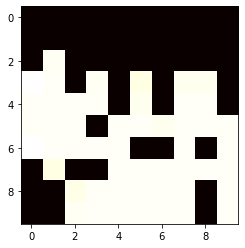

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,.,c,a,b,a,2,a,a,2
D,a,.,c,.,a,.,a,.,.,a
E,.,.,.,.,a,.,a,.,.,a
F,.,.,.,c,.,.,.,.,.,.
G,.,.,.,.,.,a,a,.,c,.
H,a,.,a,a,.,.,.,.,.,.
I,2,a,.,.,.,.,.,.,b,.
J,a,a,.,.,.,.,.,.,b,.



Turno: 49 Puntos:382
Almacen: [.] Actual: [a]


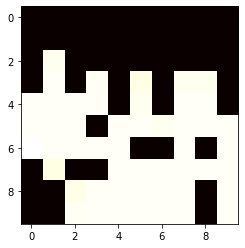

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,.,c,a,b,a,2,a,a,2
D,a,.,c,.,a,.,a,.,.,a
E,.,.,.,.,a,.,a,.,.,a
F,.,.,.,c,.,.,.,.,.,.
G,a,.,.,.,.,a,a,.,c,.
H,a,.,a,a,.,.,.,.,.,.
I,2,a,.,.,.,.,.,.,b,.
J,a,a,.,.,.,.,.,.,b,.



Turno: 50 Puntos:383
Almacen: [.] Actual: [a]


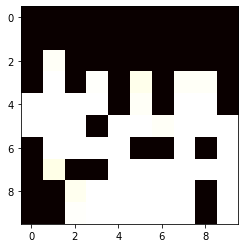

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,.,.,c,a,b,a,2,a,a,2
D,.,b,c,.,a,.,a,.,.,a
E,.,.,.,.,a,.,a,.,.,a
F,.,.,.,c,.,.,.,.,.,.
G,a,.,.,.,.,a,a,.,c,.
H,a,.,a,a,.,.,.,.,.,.
I,2,a,.,.,.,.,.,.,b,.
J,a,a,.,.,.,.,.,.,b,.



Turno: 51 Puntos:386
Almacen: [.] Actual: [a]


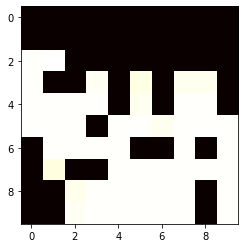

,0,1,2,3,4,5,6,7,8,9
A,2,.,2,a,b,2,a,a,2,a
B,b,.,d,2,2,a,c,2,b,d
C,.,b,c,a,b,a,2,a,a,2
D,.,b,c,.,a,.,a,.,.,a
E,.,.,.,.,a,.,a,.,.,a
F,.,.,.,c,.,.,.,.,.,.
G,a,.,.,.,.,a,a,.,c,.
H,a,.,a,a,.,.,.,.,.,.
I,2,a,.,.,.,.,.,.,b,.
J,a,a,.,.,.,.,.,.,b,.



Turno: 52 Puntos:389
Almacen: [.] Actual: [a]


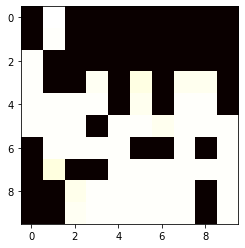

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,.,d,2,2,a,c,2,b,d
C,.,b,c,a,b,a,2,a,a,2
D,.,b,c,.,a,.,a,.,.,a
E,.,.,.,.,a,.,a,.,.,a
F,.,.,.,c,.,.,.,.,.,.
G,a,.,.,.,.,a,a,.,c,.
H,a,.,a,a,.,.,.,.,.,.
I,2,a,.,.,.,.,.,.,b,.
J,a,a,.,.,.,.,.,.,b,.



Turno: 53 Puntos:390
Almacen: [.] Actual: [b]


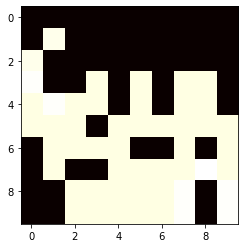

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,.,d,2,2,a,c,2,b,d
C,.,b,c,a,b,a,2,a,a,2
D,.,b,c,.,a,.,a,.,.,a
E,.,.,.,.,a,.,a,.,.,a
F,.,.,.,c,.,.,.,.,.,.
G,a,.,.,.,.,a,a,.,c,.
H,a,.,a,a,.,.,.,.,c,.
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 54 Puntos:405
Almacen: [.] Actual: [a]


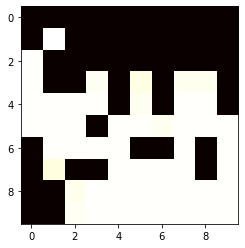

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,.,b,c,a,b,a,2,a,a,2
D,.,b,c,.,a,.,a,.,.,a
E,.,.,.,.,a,.,a,.,.,a
F,.,.,.,c,.,.,.,.,.,.
G,a,.,.,.,.,a,a,.,c,.
H,a,.,a,a,.,.,.,.,c,.
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 55 Puntos:406
Almacen: [.] Actual: [b]


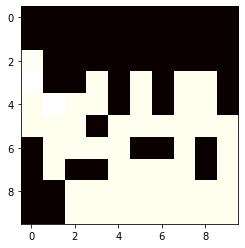

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,.,.,c,a,b,a,2,a,a,2
D,c,.,c,.,a,.,a,.,.,a
E,.,.,.,.,a,.,a,.,.,a
F,.,.,.,c,.,.,.,.,.,.
G,a,.,.,.,.,a,a,.,c,.
H,a,.,a,a,.,.,.,.,c,.
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 56 Puntos:421
Almacen: [.] Actual: [a]


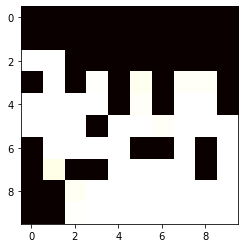

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,.,c,a,b,a,2,a,a,2
D,c,.,c,.,a,.,a,.,.,a
E,.,.,.,.,a,.,a,.,.,a
F,.,.,.,c,.,.,.,.,.,.
G,a,.,.,.,.,a,a,.,c,.
H,a,.,a,a,.,.,.,.,c,.
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 57 Puntos:422
Almacen: [.] Actual: [a]


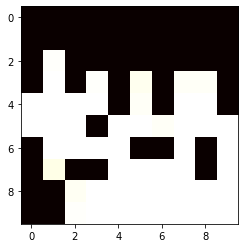

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,.,c,a,b,a,2,a,a,2
D,c,a,c,.,a,.,a,.,.,a
E,.,.,.,.,a,.,a,.,.,a
F,.,.,.,c,.,.,.,.,.,.
G,a,.,.,.,.,a,a,.,c,.
H,a,.,a,a,.,.,.,.,c,.
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 58 Puntos:423
Almacen: [.] Actual: [a]


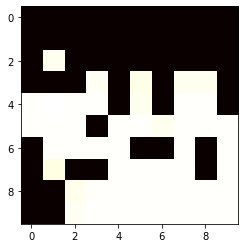

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,.,c,a,b,a,2,a,a,2
D,c,a,c,.,a,.,a,.,.,a
E,.,a,.,.,a,.,a,.,.,a
F,.,.,.,c,.,.,.,.,.,.
G,a,.,.,.,.,a,a,.,c,.
H,a,.,a,a,.,.,.,.,c,.
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 59 Puntos:424
Almacen: [.] Actual: [b]


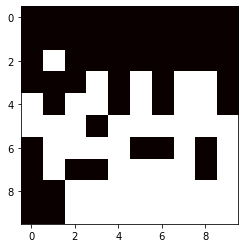

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,c,a,b,a,2,a,a,2
D,c,a,c,.,a,.,a,.,.,a
E,.,a,.,.,a,.,a,.,.,a
F,.,.,.,c,.,.,.,.,.,.
G,a,.,.,.,.,a,a,.,c,.
H,a,.,a,a,.,.,.,.,c,.
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 60 Puntos:429
Almacen: [.] Actual: [b]


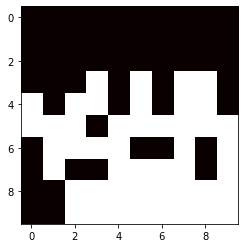

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,c,a,b,a,2,a,a,2
D,c,a,c,b,a,.,a,.,.,a
E,.,a,.,.,a,.,a,.,.,a
F,.,.,.,c,.,.,.,.,.,.
G,a,.,.,.,.,a,a,.,c,.
H,a,.,a,a,.,.,.,.,c,.
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 61 Puntos:434
Almacen: [.] Actual: [1]


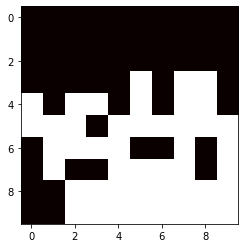

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,c,a,b,a,2,a,a,2
D,c,a,c,b,a,1,a,.,.,a
E,.,a,.,.,a,.,a,.,.,a
F,.,.,.,c,.,.,.,.,.,.
G,a,.,.,.,.,a,a,.,c,.
H,a,.,a,a,.,.,.,.,c,.
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 62 Puntos:409
Almacen: [.] Actual: [a]


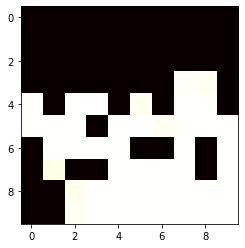

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,c,a,b,a,2,a,a,2
D,c,a,c,b,.,.,a,.,.,a
E,.,a,.,b,.,1,a,.,.,a
F,.,.,.,c,.,.,.,.,.,.
G,a,.,.,.,.,a,a,.,c,.
H,a,.,a,a,.,.,.,.,c,.
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 63 Puntos:412
Almacen: [.] Actual: [a]


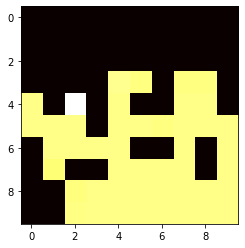

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,.,a,b,a,2,a,a,2
D,c,.,.,.,.,1,a,.,.,a
E,.,.,d,.,.,.,a,.,.,a
F,.,.,.,c,.,.,.,.,.,.
G,a,.,.,.,.,a,a,.,c,.
H,a,.,a,a,.,.,.,.,c,.
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 64 Puntos:475
Almacen: [.] Actual: [b]


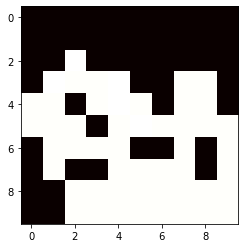

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,b,a,b,a,2,a,a,2
D,c,.,.,.,.,.,a,.,.,a
E,.,.,d,.,.,1,a,.,.,a
F,.,.,.,c,.,.,.,.,.,.
G,a,.,.,.,.,a,a,.,c,.
H,a,.,a,a,.,.,.,.,c,.
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 65 Puntos:480
Almacen: [.] Actual: [a]


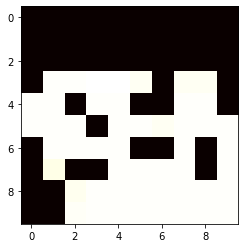

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,b,a,b,a,2,a,a,2
D,c,.,.,a,.,1,a,.,.,a
E,.,.,d,.,.,.,a,.,.,a
F,.,.,.,c,.,.,.,.,.,.
G,a,.,.,.,.,a,a,.,c,.
H,a,.,a,a,.,.,.,.,c,.
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 66 Puntos:481
Almacen: [.] Actual: [a]


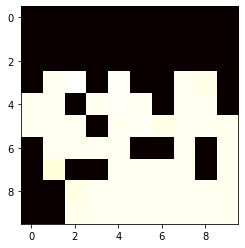

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,.,.,.,b,a,2,a,a,2
D,c,.,c,.,.,.,a,.,.,a
E,.,.,d,.,.,1,a,.,.,a
F,.,.,.,c,.,.,.,.,.,.
G,a,.,.,.,.,a,a,.,c,.
H,a,.,a,a,.,.,.,.,c,.
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 67 Puntos:494
Almacen: [.] Actual: [a]


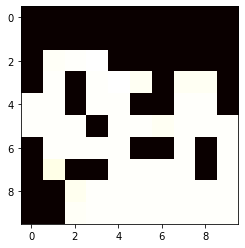

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,.,.,a,b,a,2,a,a,2
D,c,.,c,.,.,1,a,.,.,a
E,.,.,d,.,.,.,a,.,.,a
F,.,.,.,c,.,.,.,.,.,.
G,a,.,.,.,.,a,a,.,c,.
H,a,.,a,a,.,.,.,.,c,.
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 68 Puntos:495
Almacen: [.] Actual: [b]


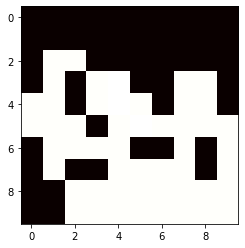

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,.,.,a,b,a,2,a,a,2
D,c,.,c,.,b,.,a,.,.,a
E,.,.,d,.,.,1,a,.,.,a
F,.,.,.,c,.,.,.,.,.,.
G,a,.,.,.,.,a,a,.,c,.
H,a,.,a,a,.,.,.,.,c,.
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 69 Puntos:500
Almacen: [.] Actual: [a]


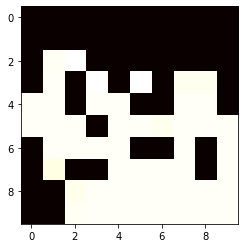

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,.,c,2,b,d
C,a,.,.,a,.,.,2,a,a,2
D,c,.,c,.,.,c,.,.,.,a
E,.,.,d,.,.,.,1,.,.,a
F,.,.,.,c,.,.,.,.,.,.
G,a,.,.,.,.,a,a,.,c,.
H,a,.,a,a,.,.,.,.,c,.
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 70 Puntos:511
Almacen: [.] Actual: [a]


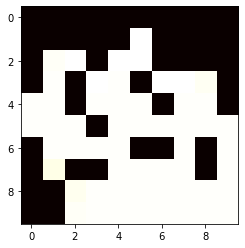

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,.,.,a,.,.,2,a,a,2
D,c,.,c,.,.,c,1,.,.,a
E,.,.,d,.,.,.,.,.,.,a
F,.,.,.,c,.,.,.,.,.,.
G,a,.,.,.,.,a,a,.,c,.
H,a,.,a,a,.,.,.,.,c,.
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 71 Puntos:512
Almacen: [.] Actual: [a]


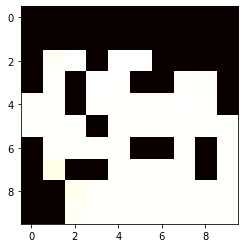

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,.,a,a,.,.,2,a,a,2
D,c,.,c,.,.,c,.,1,.,a
E,.,.,d,.,.,.,.,.,.,a
F,.,.,.,c,.,.,.,.,.,.
G,a,.,.,.,.,a,a,.,c,.
H,a,.,a,a,.,.,.,.,c,.
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 72 Puntos:513
Almacen: [.] Actual: [a]


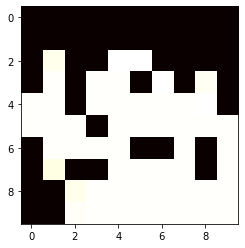

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,.,.,.,b,.,2,a,a,2
D,c,.,c,.,.,c,.,x,1,a
E,.,.,d,.,.,.,.,.,.,a
F,.,.,.,c,.,.,.,.,.,.
G,a,.,.,.,.,a,a,.,c,.
H,a,.,a,a,.,.,.,.,c,.
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 73 Puntos:466
Almacen: [.] Actual: [a]


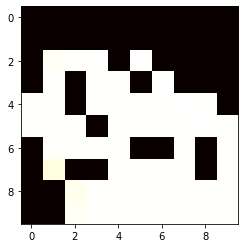

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,.,.,a,b,.,2,a,a,2
D,c,.,c,.,.,c,.,x,x,a
E,.,.,d,.,.,.,.,.,1,a
F,.,.,.,c,.,.,.,.,.,.
G,a,.,.,.,.,a,a,.,c,.
H,a,.,a,a,.,.,.,.,c,.
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 74 Puntos:417
Almacen: [.] Actual: [a]


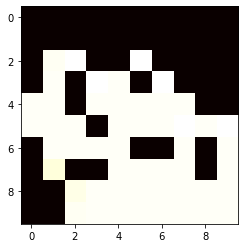

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,.,a,a,b,.,2,a,a,2
D,c,.,c,.,.,c,.,x,x,a
E,.,.,d,.,.,.,.,.,x,a
F,.,.,.,c,.,.,.,.,1,.
G,a,.,.,.,.,a,a,.,c,.
H,a,.,a,a,.,.,.,.,c,.
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 75 Puntos:368
Almacen: [.] Actual: [a]


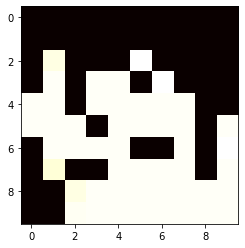

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,.,a,a,b,a,2,a,a,2
D,c,.,c,.,.,c,.,x,x,a
E,.,.,d,.,.,.,.,.,x,a
F,.,.,.,c,.,.,.,.,x,1
G,a,.,.,.,.,a,a,.,c,.
H,a,.,a,a,.,.,.,.,c,.
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 76 Puntos:319
Almacen: [.] Actual: [a]


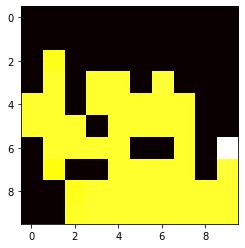

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,.,a,a,b,a,2,a,a,2
D,c,.,c,.,.,c,.,x,x,a
E,.,.,d,.,.,.,.,.,x,a
F,.,.,.,c,.,.,.,.,x,2
G,a,.,.,.,.,a,a,.,c,a
H,a,.,a,a,.,.,.,.,c,.
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 77 Puntos:340
Almacen: [.] Actual: [a]


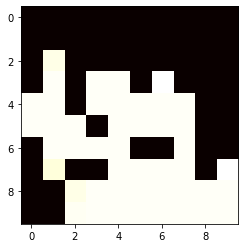

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,.,a,a,b,a,2,a,a,2
D,c,.,c,.,.,c,a,x,x,a
E,.,.,d,.,.,.,.,.,x,a
F,.,.,.,c,.,.,.,.,x,2
G,a,.,.,.,.,a,a,.,c,a
H,a,.,a,a,.,.,.,.,c,.
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 78 Puntos:341
Almacen: [.] Actual: [a]


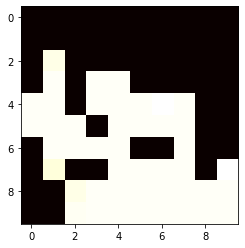

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,.,a,a,b,a,2,a,a,2
D,c,.,c,.,.,c,a,x,x,a
E,.,.,d,.,.,.,a,.,x,a
F,.,.,.,c,.,.,.,.,x,2
G,a,.,.,.,.,a,a,.,c,a
H,a,.,a,a,.,.,.,.,c,.
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 79 Puntos:342
Almacen: [.] Actual: [a]


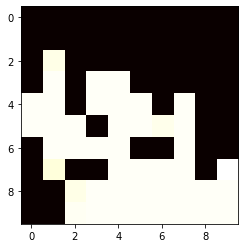

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,.,a,a,b,a,2,a,a,2
D,c,.,c,.,.,c,a,x,x,a
E,.,.,d,.,.,.,a,.,x,a
F,.,.,.,c,.,.,.,.,x,2
G,a,.,.,.,.,a,a,.,c,a
H,a,.,a,a,.,.,.,.,c,a
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 80 Puntos:343
Almacen: [.] Actual: [a]


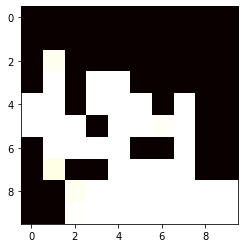

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,.,a,a,b,a,2,a,a,2
D,c,a,c,.,.,c,a,x,x,a
E,.,.,d,.,.,.,a,.,x,a
F,.,.,.,c,.,.,.,.,x,2
G,a,.,.,.,.,a,a,.,c,a
H,a,.,a,a,.,.,.,.,c,a
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 81 Puntos:344
Almacen: [.] Actual: [a]


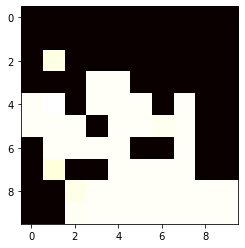

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,.,a,a,b,a,2,a,a,2
D,c,a,c,.,.,c,a,x,x,a
E,.,a,d,.,.,.,a,.,x,a
F,.,.,.,c,.,.,.,.,x,2
G,a,.,.,.,.,a,a,.,c,a
H,a,.,a,a,.,.,.,.,c,a
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 82 Puntos:345
Almacen: [.] Actual: [c]


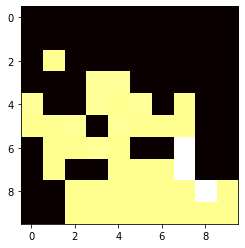

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,.,a,a,b,a,2,a,a,2
D,c,a,c,.,.,c,a,x,x,a
E,.,a,d,.,.,.,a,.,x,a
F,.,.,.,c,.,.,.,.,x,2
G,a,.,.,.,.,a,a,d,.,a
H,a,.,a,a,.,.,.,.,.,a
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 83 Puntos:420
Almacen: [.] Actual: [c]


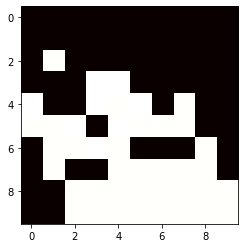

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,.,a,a,b,a,2,a,a,2
D,c,a,c,c,.,c,a,x,x,a
E,.,a,d,.,.,.,a,.,x,a
F,.,.,.,c,.,.,.,.,x,2
G,a,.,.,.,.,a,a,d,.,a
H,a,.,a,a,.,.,.,.,.,a
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 84 Puntos:445
Almacen: [.] Actual: [a]


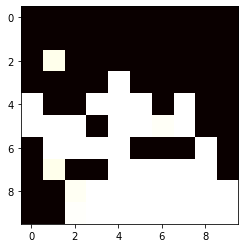

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,.,a,a,b,a,2,a,a,2
D,c,a,c,c,a,c,a,x,x,a
E,.,a,d,.,.,.,a,.,x,a
F,.,.,.,c,.,.,.,.,x,2
G,a,.,.,.,.,a,a,d,.,a
H,a,.,a,a,.,.,.,.,.,a
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 85 Puntos:446
Almacen: [.] Actual: [a]


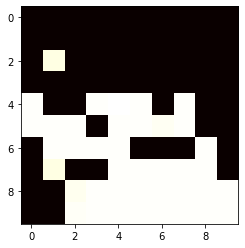

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,.,a,a,b,a,2,a,a,2
D,c,a,c,c,a,c,a,x,x,a
E,.,a,d,.,a,.,a,.,x,a
F,.,.,.,c,.,.,.,.,x,2
G,a,.,.,.,.,a,a,d,.,a
H,a,.,a,a,.,.,.,.,.,a
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 86 Puntos:447
Almacen: [.] Actual: [a]


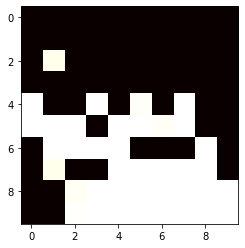

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,.,a,a,b,a,2,a,a,2
D,c,.,c,c,a,c,a,x,x,a
E,b,.,d,.,a,.,a,.,x,a
F,.,.,.,c,.,.,.,.,x,2
G,a,.,.,.,.,a,a,d,.,a
H,a,.,a,a,.,.,.,.,.,a
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 87 Puntos:450
Almacen: [.] Actual: [a]


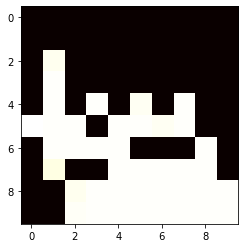

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,.,a,a,b,a,2,a,a,2
D,c,.,c,c,a,c,a,x,x,a
E,b,.,d,.,a,.,a,.,x,a
F,b,.,.,c,.,.,.,.,x,2
G,.,.,.,.,.,a,a,d,.,a
H,.,.,a,a,.,.,.,.,.,a
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 88 Puntos:453
Almacen: [.] Actual: [a]


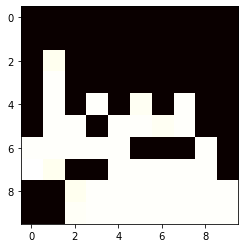

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,.,a,a,b,a,2,a,a,2
D,c,.,c,c,a,c,a,x,x,a
E,b,.,d,.,a,.,a,.,x,a
F,b,.,.,c,.,.,.,.,x,2
G,.,.,.,.,.,a,a,d,.,a
H,a,.,a,a,.,.,.,.,.,a
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 89 Puntos:454
Almacen: [.] Actual: [a]


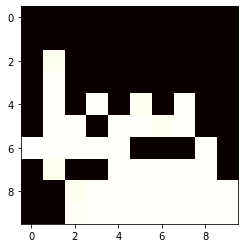

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,.,a,a,b,a,2,a,a,2
D,c,.,c,c,a,c,a,x,x,a
E,b,.,d,.,a,.,a,.,x,a
F,b,.,.,c,.,.,.,.,x,2
G,a,.,.,.,.,a,a,d,.,a
H,a,.,a,a,.,.,.,.,.,a
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 90 Puntos:455
Almacen: [.] Actual: [1]


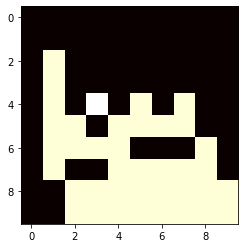

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,.,a,a,b,a,2,a,a,2
D,c,.,c,c,a,c,a,x,x,a
E,b,.,d,2,a,.,a,.,x,a
F,b,.,.,c,.,.,.,.,x,2
G,a,.,.,.,.,a,a,d,.,a
H,a,.,a,a,.,.,.,.,.,a
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 91 Puntos:450
Almacen: [.] Actual: [b]


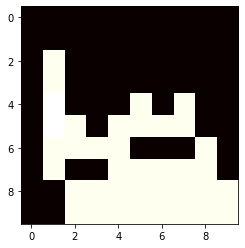

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,.,a,a,b,a,2,a,a,2
D,c,.,c,c,a,c,a,x,x,a
E,.,c,d,2,a,.,a,.,x,a
F,.,.,.,c,.,.,.,.,x,2
G,a,.,.,.,.,a,a,d,.,a
H,a,.,a,a,.,.,.,.,.,a
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 92 Puntos:465
Almacen: [.] Actual: [a]


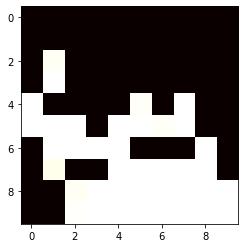

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,.,a,a,b,a,2,a,a,2
D,c,a,c,c,a,c,a,x,x,a
E,.,c,d,2,a,.,a,.,x,a
F,.,.,.,c,.,.,.,.,x,2
G,a,.,.,.,.,a,a,d,.,a
H,a,.,a,a,.,.,.,.,.,a
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 93 Puntos:466
Almacen: [.] Actual: [a]


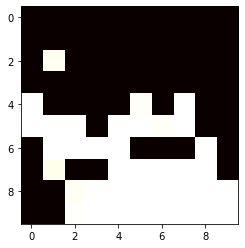

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,.,a,a,b,a,2,a,a,2
D,c,a,c,c,a,c,a,x,x,a
E,a,c,d,2,a,.,a,.,x,a
F,.,.,.,c,.,.,.,.,x,2
G,a,.,.,.,.,a,a,d,.,a
H,a,.,a,a,.,.,.,.,.,a
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 94 Puntos:467
Almacen: [.] Actual: [b]


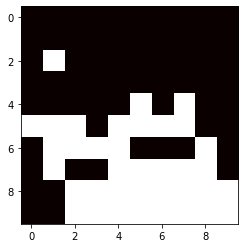

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,a,2
D,c,a,c,c,a,c,a,x,x,a
E,a,c,d,2,a,.,a,.,x,a
F,.,.,.,c,.,.,.,.,x,2
G,a,.,.,.,.,a,a,d,.,a
H,a,.,a,a,.,.,.,.,.,a
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 95 Puntos:472
Almacen: [.] Actual: [a]


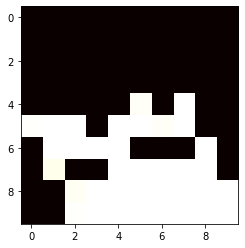

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,a,2
D,c,a,c,c,a,c,.,x,x,a
E,a,c,d,2,a,.,.,b,x,a
F,.,.,.,c,.,.,.,.,x,2
G,a,.,.,.,.,a,a,d,.,a
H,a,.,a,a,.,.,.,.,.,a
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 96 Puntos:475
Almacen: [.] Actual: [1]


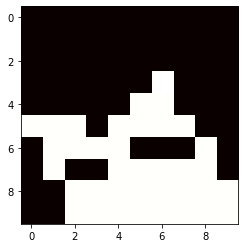

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,a,2
D,c,a,c,c,a,c,1,x,x,a
E,a,c,d,2,a,.,.,b,x,a
F,.,.,.,c,.,.,.,.,x,2
G,a,.,.,.,.,a,a,d,.,a
H,a,.,a,a,.,.,.,.,.,a
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 97 Puntos:450
Almacen: [.] Actual: [a]


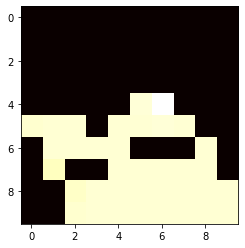

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,a,2
D,c,a,c,c,a,c,2,x,x,a
E,a,c,d,2,a,.,a,b,x,a
F,.,.,.,c,.,.,.,.,x,2
G,a,.,.,.,.,a,a,d,.,a
H,a,.,a,a,.,.,.,.,.,a
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 98 Puntos:471
Almacen: [.] Actual: [a]


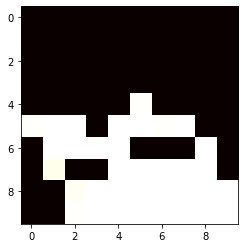

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,a,2
D,c,a,c,c,a,c,2,x,x,a
E,a,c,d,2,a,.,a,b,x,a
F,.,a,.,c,.,.,.,.,x,2
G,a,.,.,.,.,a,a,d,.,a
H,a,.,a,a,.,.,.,.,.,a
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 99 Puntos:472
Almacen: [.] Actual: [a]


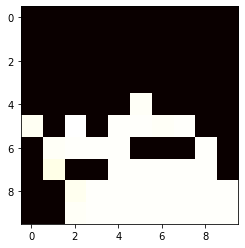

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,a,2
D,c,a,c,c,a,c,2,x,x,a
E,a,c,d,2,a,.,a,b,x,a
F,.,a,a,c,.,.,.,.,x,2
G,a,.,.,.,.,a,a,d,.,a
H,a,.,a,a,.,.,.,.,.,a
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 100 Puntos:473
Almacen: [.] Actual: [a]


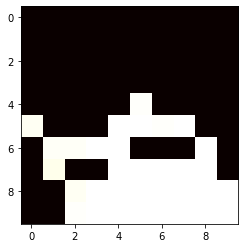

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,a,2
D,c,a,c,c,.,c,2,x,x,a
E,a,c,d,2,.,.,a,b,x,a
F,.,a,a,c,b,.,.,.,x,2
G,a,.,.,.,.,a,a,d,.,a
H,a,.,a,a,.,.,.,.,.,a
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 101 Puntos:476
Almacen: [.] Actual: [w]


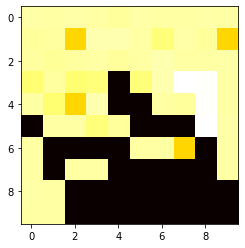

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,a,2
D,c,a,c,c,.,c,2,.,x,a
E,a,c,d,2,.,.,a,b,x,a
F,.,a,a,c,b,.,.,.,x,2
G,a,.,.,.,.,a,a,d,.,a
H,a,.,a,a,.,.,.,.,.,a
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 102 Puntos:526
Almacen: [.] Actual: [a]


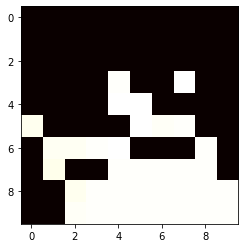

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,.,.,2
D,c,a,c,c,.,c,2,b,x,a
E,a,c,d,2,.,.,a,b,x,a
F,.,a,a,c,b,.,.,.,x,2
G,a,.,.,.,.,a,a,d,.,a
H,a,.,a,a,.,.,.,.,.,a
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 103 Puntos:529
Almacen: [.] Actual: [a]


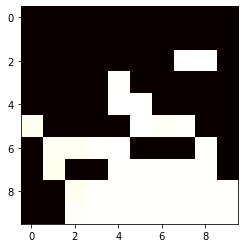

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,.,2
D,c,a,c,c,.,c,2,b,x,a
E,a,c,d,2,.,.,a,b,x,a
F,.,a,a,c,b,.,.,.,x,2
G,a,.,.,.,.,a,a,d,.,a
H,a,.,a,a,.,.,.,.,.,a
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 104 Puntos:530
Almacen: [.] Actual: [a]


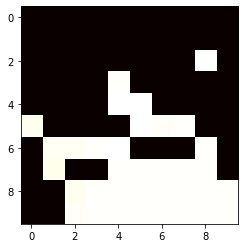

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,a,2
D,c,a,c,c,.,c,2,b,x,a
E,a,c,d,2,.,.,a,b,x,a
F,.,a,a,c,b,.,.,.,x,2
G,a,.,.,.,.,a,a,d,.,a
H,a,.,a,a,.,.,.,.,.,a
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 105 Puntos:531
Almacen: [.] Actual: [a]


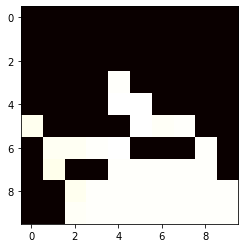

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,a,2
D,c,a,c,c,.,c,2,b,x,a
E,a,c,d,2,a,.,a,b,x,a
F,.,a,a,c,b,.,.,.,x,2
G,a,.,.,.,.,a,a,d,.,a
H,a,.,a,a,.,.,.,.,.,a
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 106 Puntos:532
Almacen: [.] Actual: [1]


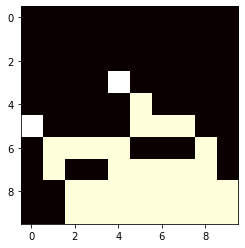

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,a,2
D,c,a,c,c,2,c,2,b,x,a
E,a,c,d,2,a,.,a,b,x,a
F,.,a,a,c,b,.,.,.,x,2
G,a,.,.,.,.,a,a,d,.,a
H,a,.,a,a,.,.,.,.,.,a
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 107 Puntos:527
Almacen: [.] Actual: [b]


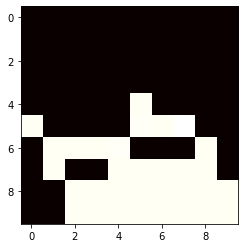

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,a,2
D,c,a,c,c,2,c,2,.,x,a
E,a,c,d,2,a,.,a,.,x,a
F,.,a,a,c,b,.,.,c,x,2
G,a,.,.,.,.,a,a,d,.,a
H,a,.,a,a,.,.,.,.,.,a
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 108 Puntos:542
Almacen: [.] Actual: [1]


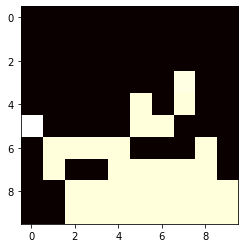

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,a,2
D,c,a,c,c,2,c,2,.,x,a
E,a,c,d,2,a,.,a,.,x,a
F,2,a,a,c,b,.,.,c,x,2
G,a,.,.,.,.,a,a,d,.,a
H,a,.,a,a,.,.,.,.,.,a
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 109 Puntos:537
Almacen: [.] Actual: [a]


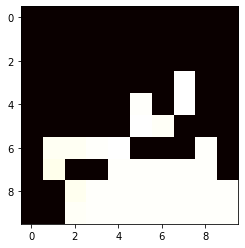

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,.,.,2
D,c,a,c,c,2,c,2,b,x,a
E,a,c,d,2,a,.,a,.,x,a
F,2,a,a,c,b,.,.,c,x,2
G,a,.,.,.,.,a,a,d,.,a
H,a,.,a,a,.,.,.,.,.,a
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 110 Puntos:540
Almacen: [.] Actual: [a]


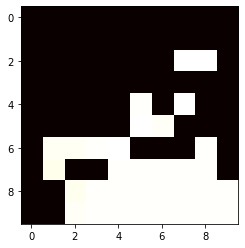

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,.,2
D,c,a,c,c,2,c,2,b,x,a
E,a,c,d,2,a,.,a,.,x,a
F,2,a,a,c,b,.,.,c,x,2
G,a,.,.,.,.,a,a,d,.,a
H,a,.,a,a,.,.,.,.,.,a
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 111 Puntos:541
Almacen: [.] Actual: [1]


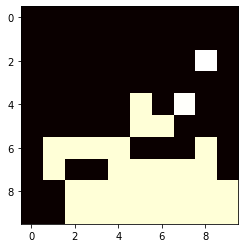

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,x,a
E,a,c,d,2,a,.,a,.,x,a
F,2,a,a,c,b,.,.,c,x,2
G,a,.,.,.,.,a,a,d,.,a
H,a,.,a,a,.,.,.,.,.,a
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 112 Puntos:536
Almacen: [.] Actual: [a]


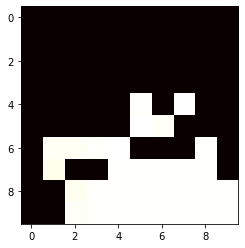

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,x,a
E,a,c,d,2,a,.,a,a,x,a
F,2,a,a,c,b,.,.,c,x,2
G,a,.,.,.,.,a,a,d,.,a
H,a,.,a,a,.,.,.,.,.,a
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 113 Puntos:537
Almacen: [.] Actual: [a]


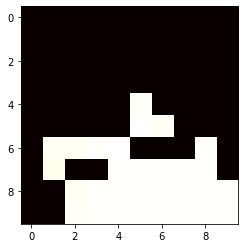

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,x,a
E,a,c,d,2,a,.,a,a,x,a
F,2,a,a,c,b,b,.,c,x,2
G,a,.,.,.,.,.,.,d,.,a
H,a,.,a,a,.,.,.,.,.,a
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 114 Puntos:540
Almacen: [.] Actual: [a]


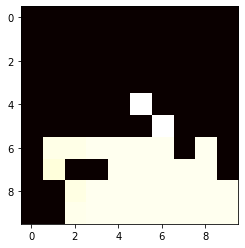

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,x,a
E,a,c,d,2,a,.,.,.,x,a
F,2,a,a,c,.,.,c,c,x,2
G,a,.,.,.,.,.,.,d,.,a
H,a,.,a,a,.,.,.,.,.,a
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 115 Puntos:553
Almacen: [.] Actual: [1]


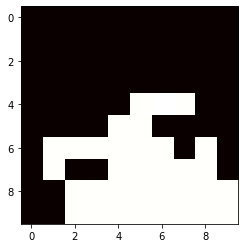

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,x,a
E,a,c,d,2,a,.,1,.,x,a
F,2,a,a,c,.,.,c,c,x,2
G,a,.,.,.,.,.,.,d,.,a
H,a,.,a,a,.,.,.,.,.,a
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 116 Puntos:528
Almacen: [.] Actual: [a]


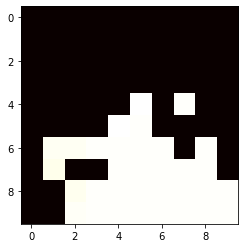

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,x,a
E,a,c,d,2,a,a,.,1,x,a
F,2,a,a,c,.,.,c,c,x,2
G,a,.,.,.,.,.,.,d,.,a
H,a,.,a,a,.,.,.,.,.,a
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 117 Puntos:529
Almacen: [.] Actual: [a]


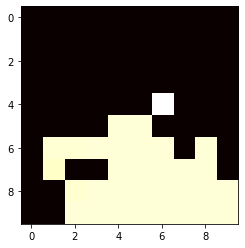

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,x,a
E,a,c,d,2,.,.,b,2,x,a
F,2,a,a,c,.,.,c,c,x,2
G,a,.,.,.,.,.,.,d,.,a
H,a,.,a,a,.,.,.,.,.,a
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 118 Puntos:552
Almacen: [.] Actual: [a]


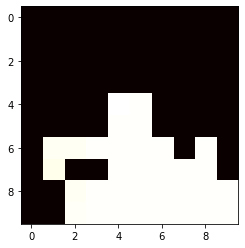

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,x,a
E,a,c,d,2,a,.,b,2,x,a
F,2,a,a,c,.,.,c,c,x,2
G,a,.,.,.,.,.,.,d,.,a
H,a,.,a,a,.,.,.,.,.,a
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 119 Puntos:553
Almacen: [.] Actual: [b]


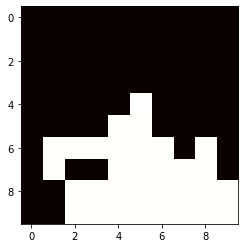

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,x,a
E,a,c,d,2,a,b,b,2,x,a
F,2,a,a,c,.,.,c,c,x,2
G,a,.,.,.,.,.,.,d,.,a
H,a,.,a,a,.,.,.,.,.,a
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 120 Puntos:558
Almacen: [.] Actual: [1]


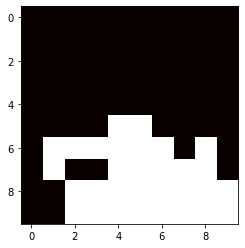

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,x,a
E,a,c,d,2,a,b,b,2,x,a
F,2,a,a,c,1,.,c,c,x,2
G,a,.,.,.,.,.,.,d,.,a
H,a,.,a,a,.,.,.,.,.,a
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 121 Puntos:533
Almacen: [.] Actual: [a]


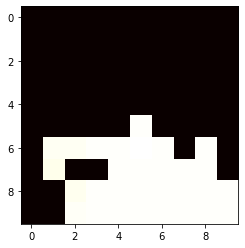

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,x,a
E,a,c,d,2,a,b,b,2,x,a
F,2,a,a,c,.,1,c,c,x,2
G,a,.,.,.,.,a,.,d,.,a
H,a,.,a,a,.,.,.,.,.,a
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 122 Puntos:534
Almacen: [.] Actual: [a]


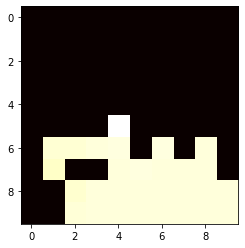

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,x,a
E,a,c,d,2,a,b,b,2,x,a
F,2,a,a,c,a,2,c,c,x,2
G,a,.,.,.,.,a,.,d,.,a
H,a,.,a,a,.,.,.,.,.,a
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 123 Puntos:555
Almacen: [.] Actual: [a]


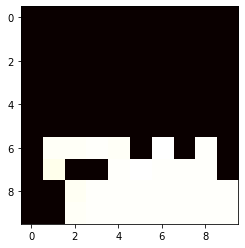

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,x,a
E,a,c,d,2,a,b,b,2,x,a
F,2,a,a,c,a,2,c,c,x,2
G,a,.,.,.,.,a,a,d,.,a
H,a,.,a,a,.,.,.,.,.,a
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 124 Puntos:556
Almacen: [.] Actual: [a]


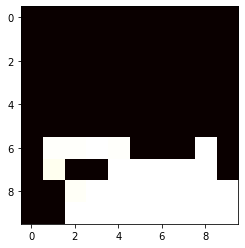

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,x,a
E,a,c,d,2,a,b,b,2,x,a
F,2,a,a,c,a,2,c,c,x,2
G,a,.,.,b,.,a,a,d,.,a
H,a,.,.,.,.,.,.,.,.,a
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 125 Puntos:559
Almacen: [.] Actual: [1]


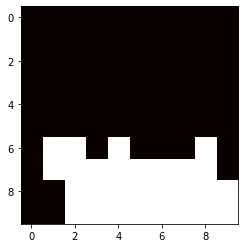

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,x,a
E,a,c,d,2,a,b,b,2,x,a
F,2,a,a,c,a,2,c,c,x,2
G,a,1,.,b,.,a,a,d,.,a
H,a,.,.,.,.,.,.,.,.,a
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 126 Puntos:534
Almacen: [.] Actual: [a]


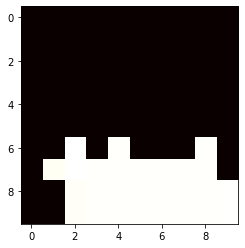

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,x,a
E,a,c,d,2,a,b,b,2,x,a
F,2,1,.,c,a,2,c,c,x,2
G,a,.,b,b,.,a,a,d,.,a
H,a,.,.,.,.,.,.,.,.,a
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 127 Puntos:537
Almacen: [.] Actual: [a]


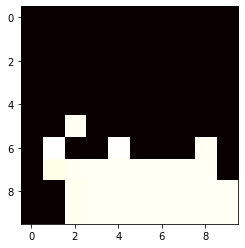

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,x,a
E,a,c,d,2,a,b,b,2,x,a
F,2,.,1,c,a,2,c,c,x,2
G,.,c,.,.,.,a,a,d,.,a
H,.,.,.,.,.,.,.,.,.,a
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 128 Puntos:550
Almacen: [.] Actual: [1]


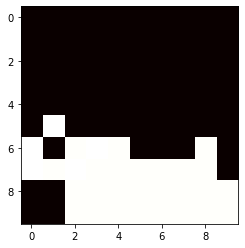

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,x,a
E,a,c,d,2,a,b,b,2,x,a
F,2,1,.,c,a,2,c,c,x,2
G,.,c,1,.,.,a,a,d,.,a
H,.,.,.,.,.,.,.,.,.,a
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 129 Puntos:525
Almacen: [.] Actual: [a]


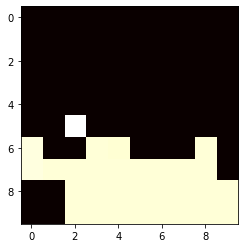

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,x,a
E,a,c,d,2,a,b,b,2,x,a
F,2,2,a,c,a,2,c,c,x,2
G,.,c,.,1,.,a,a,d,.,a
H,.,.,.,.,.,.,.,.,.,a
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 130 Puntos:546
Almacen: [.] Actual: [a]


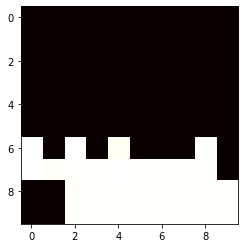

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,x,a
E,a,c,d,2,a,b,b,2,x,a
F,2,2,a,c,a,2,c,c,x,2
G,a,c,.,.,1,a,a,d,.,a
H,.,.,.,.,.,.,.,.,.,a
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 131 Puntos:547
Almacen: [.] Actual: [a]


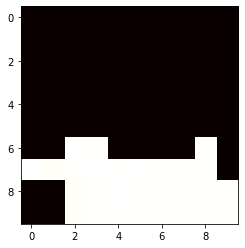

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,x,a
E,a,c,d,2,a,b,b,2,x,a
F,2,2,a,c,a,2,c,c,x,2
G,a,c,a,.,.,a,a,d,.,a
H,.,.,.,.,1,.,.,.,.,a
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 132 Puntos:548
Almacen: [.] Actual: [a]


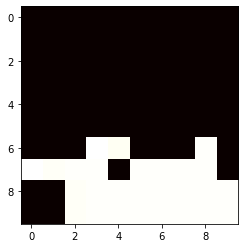

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,x,a
E,a,c,d,2,a,b,b,2,x,a
F,2,2,.,c,a,2,c,c,x,2
G,a,c,.,b,1,a,a,d,.,a
H,.,.,.,.,.,.,.,.,.,a
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 133 Puntos:551
Almacen: [.] Actual: [a]


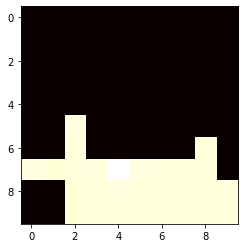

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,x,a
E,a,c,d,2,a,b,b,2,x,a
F,2,2,.,c,a,2,c,c,x,2
G,a,c,.,b,2,a,a,d,.,a
H,.,.,.,.,a,.,.,.,.,a
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 134 Puntos:572
Almacen: [.] Actual: [b]


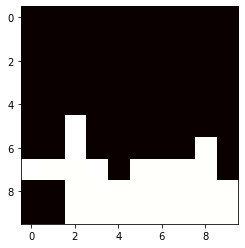

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,x,a
E,a,c,d,2,a,b,b,2,x,a
F,2,2,b,c,a,2,c,c,x,2
G,a,c,.,b,2,a,a,d,.,a
H,.,.,.,.,a,.,.,.,.,a
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 135 Puntos:577
Almacen: [.] Actual: [b]


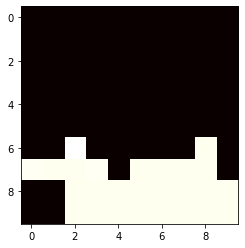

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,x,a
E,a,c,d,2,a,b,b,2,x,a
F,2,2,.,c,a,2,c,c,x,2
G,a,c,c,.,2,a,a,d,.,a
H,.,.,.,.,a,.,.,.,.,a
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 136 Puntos:592
Almacen: [.] Actual: [a]


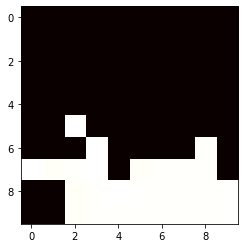

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,x,a
E,a,c,d,2,a,b,b,2,x,a
F,2,2,a,c,a,2,c,c,x,2
G,a,c,c,.,2,a,a,d,.,a
H,.,.,.,.,a,.,.,.,.,a
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 137 Puntos:593
Almacen: [.] Actual: [a]


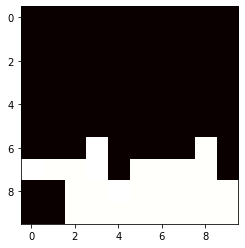

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,x,a
E,a,c,d,2,a,b,b,2,x,a
F,2,2,a,c,a,2,c,c,x,2
G,a,c,c,a,2,a,a,d,.,a
H,.,.,.,.,a,.,.,.,.,a
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 138 Puntos:594
Almacen: [.] Actual: [a]


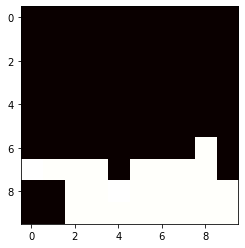

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,x,a
E,a,c,d,2,a,b,b,2,x,a
F,2,2,a,c,a,2,c,c,x,2
G,a,c,c,a,2,a,a,d,.,a
H,a,.,.,.,a,.,.,.,.,a
I,2,a,.,.,.,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 139 Puntos:595
Almacen: [.] Actual: [a]


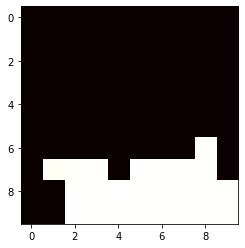

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,x,a
E,a,c,d,2,a,b,b,2,x,a
F,2,2,a,c,a,2,c,c,x,2
G,a,c,c,a,2,a,a,d,.,a
H,a,.,.,.,a,.,.,.,.,a
I,2,a,.,.,a,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 140 Puntos:596
Almacen: [.] Actual: [1]


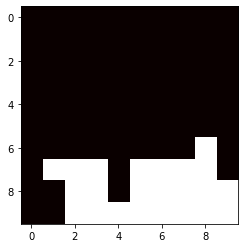

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,x,a
E,a,c,d,2,a,b,b,2,x,a
F,2,2,a,c,a,2,c,c,x,2
G,a,c,c,a,2,a,a,d,1,a
H,a,.,.,.,a,.,.,.,.,a
I,2,a,.,.,a,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 141 Puntos:571
Almacen: [.] Actual: [a]


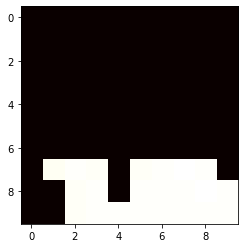

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,x,a
E,a,c,d,2,a,b,b,2,x,a
F,2,2,a,c,a,2,c,c,x,2
G,a,c,c,a,2,a,a,d,.,a
H,a,.,.,.,a,.,.,a,1,a
I,2,a,.,.,a,.,.,.,.,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 142 Puntos:572
Almacen: [.] Actual: [1]


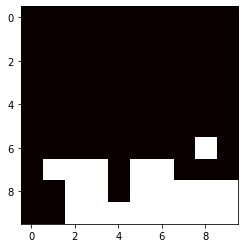

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,x,a
E,a,c,d,2,a,b,b,2,x,a
F,2,2,a,c,a,2,c,c,x,2
G,a,c,c,a,2,a,a,d,1,a
H,a,.,.,.,a,.,.,a,.,a
I,2,a,.,.,a,.,.,.,1,.
J,a,a,.,.,.,.,.,.,.,.



Turno: 143 Puntos:547
Almacen: [.] Actual: [1]


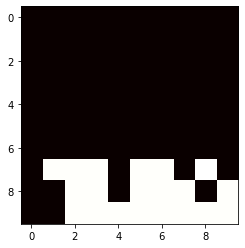

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,x,a
E,a,c,d,2,a,b,b,2,x,a
F,2,2,a,c,a,2,c,c,x,2
G,a,c,c,a,2,a,a,d,1,a
H,a,.,.,.,a,.,.,a,1,a
I,2,a,.,.,a,.,.,.,.,1
J,a,a,.,.,.,.,.,.,.,.



Turno: 144 Puntos:522
Almacen: [.] Actual: [a]


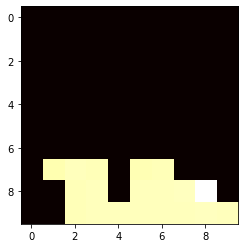

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,x,a
E,a,c,d,2,a,b,b,2,x,a
F,2,2,a,c,a,2,c,c,x,2
G,a,c,c,a,2,a,a,d,2,a
H,a,.,.,.,a,.,.,a,2,a
I,2,a,.,.,a,.,.,.,a,.
J,a,a,.,.,.,.,.,.,.,1



Turno: 145 Puntos:563
Almacen: [.] Actual: [a]


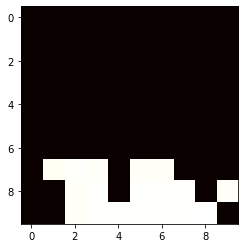

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,x,a
E,a,c,d,2,a,b,b,2,x,a
F,2,2,a,c,a,2,c,c,x,2
G,a,c,c,a,2,a,a,d,2,a
H,a,.,.,.,a,.,.,a,2,a
I,2,a,.,.,a,.,.,.,a,1
J,a,a,.,.,.,.,.,.,a,.



Turno: 146 Puntos:564
Almacen: [.] Actual: [a]


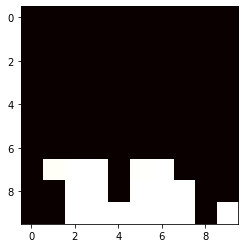

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,x,a
E,a,c,d,2,a,b,b,2,x,a
F,2,2,a,c,a,2,c,c,x,2
G,a,c,c,a,2,a,a,d,2,a
H,a,.,a,.,a,.,.,a,2,a
I,2,a,.,.,a,.,.,.,a,.
J,a,a,.,.,.,.,.,.,a,1



Turno: 147 Puntos:565
Almacen: [.] Actual: [a]


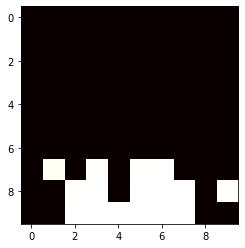

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,x,a
E,a,c,d,2,a,b,b,2,x,a
F,2,2,a,c,a,2,c,c,x,2
G,a,c,c,a,2,a,a,d,2,a
H,a,.,a,.,.,.,.,a,2,a
I,2,a,.,b,.,.,.,.,a,1
J,a,a,.,.,.,.,.,.,a,.



Turno: 148 Puntos:568
Almacen: [.] Actual: [b]


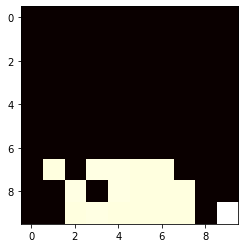

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,x,a
E,a,c,d,2,a,b,b,2,x,a
F,2,2,a,c,a,2,c,c,x,2
G,a,c,c,a,2,a,a,d,2,a
H,a,.,a,.,.,.,.,a,2,a
I,2,a,.,b,.,.,.,.,a,2
J,a,a,.,.,.,.,.,.,a,b



Turno: 149 Puntos:593
Almacen: [.] Actual: [a]


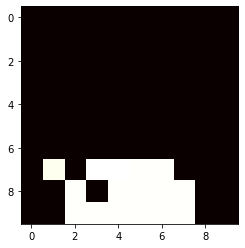

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,x,a
E,a,c,d,2,a,b,b,2,x,a
F,2,2,a,c,a,2,c,c,x,2
G,a,c,c,.,2,a,a,d,2,a
H,a,.,.,b,.,.,.,a,2,a
I,2,a,.,b,.,.,.,.,a,2
J,a,a,.,.,.,.,.,.,a,b



Turno: 150 Puntos:596
Almacen: [.] Actual: [b]


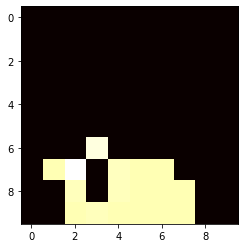

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,x,a
E,a,c,d,2,a,b,b,2,x,a
F,2,2,a,c,a,2,c,c,x,2
G,a,.,.,.,2,a,a,d,2,a
H,a,.,d,.,.,.,.,a,2,a
I,2,a,.,.,.,.,.,.,a,2
J,a,a,.,.,.,.,.,.,a,b



Turno: 151 Puntos:661
Almacen: [.] Actual: [a]


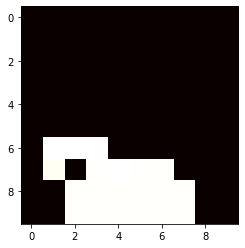

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,x,a
E,a,c,d,2,a,b,b,2,x,a
F,2,2,a,c,a,2,c,c,x,2
G,.,b,.,.,2,a,a,d,2,a
H,.,.,d,.,.,.,.,a,2,a
I,2,a,.,.,.,.,.,.,a,2
J,a,a,.,.,.,.,.,.,a,b



Turno: 152 Puntos:664
Almacen: [.] Actual: [a]


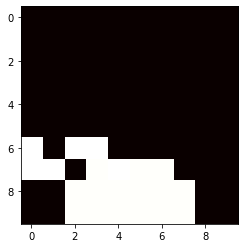

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,x,a
E,a,c,d,2,a,b,b,2,x,a
F,2,2,a,c,a,2,c,c,x,2
G,a,b,.,.,2,a,a,d,2,a
H,.,.,d,.,.,.,.,a,2,a
I,2,a,.,.,.,.,.,.,a,2
J,a,a,.,.,.,.,.,.,a,b



Turno: 153 Puntos:665
Almacen: [.] Actual: [a]


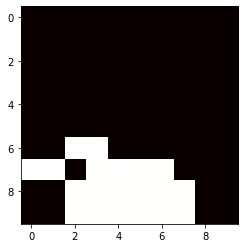

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,x,a
E,a,c,d,2,a,b,b,2,x,a
F,2,2,a,c,a,2,c,c,x,2
G,a,b,a,.,2,a,a,d,2,a
H,.,.,d,.,.,.,.,a,2,a
I,2,a,.,.,.,.,.,.,a,2
J,a,a,.,.,.,.,.,.,a,b



Turno: 154 Puntos:666
Almacen: [.] Actual: [a]


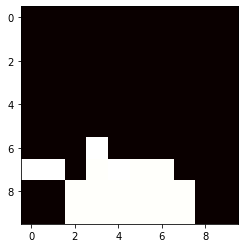

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,x,a
E,a,c,d,2,a,b,b,2,x,a
F,2,2,.,c,a,2,c,c,x,2
G,a,b,.,b,2,a,a,d,2,a
H,.,.,d,.,.,.,.,a,2,a
I,2,a,.,.,.,.,.,.,a,2
J,a,a,.,.,.,.,.,.,a,b



Turno: 155 Puntos:669
Almacen: [.] Actual: [a]


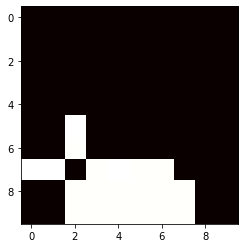

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,x,a
E,a,c,d,2,a,b,b,2,x,a
F,2,2,a,c,a,2,c,c,x,2
G,a,b,.,b,2,a,a,d,2,a
H,.,.,d,.,.,.,.,a,2,a
I,2,a,.,.,.,.,.,.,a,2
J,a,a,.,.,.,.,.,.,a,b



Turno: 156 Puntos:670
Almacen: [.] Actual: [a]


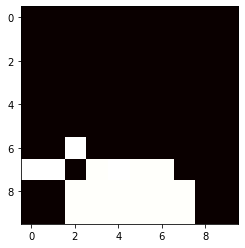

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,x,a
E,a,c,d,2,a,b,b,2,x,a
F,2,2,a,c,a,2,c,c,x,2
G,a,b,a,b,2,a,a,d,2,a
H,.,.,d,.,.,.,.,a,2,a
I,2,a,.,.,.,.,.,.,a,2
J,a,a,.,.,.,.,.,.,a,b



Turno: 157 Puntos:671
Almacen: [.] Actual: [c]


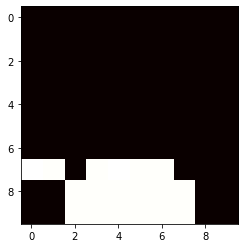

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,x,a
E,a,c,d,2,a,b,b,2,x,a
F,2,2,a,c,a,2,c,c,x,2
G,a,b,a,b,2,a,a,d,2,a
H,c,.,d,.,.,.,.,a,2,a
I,2,a,.,.,.,.,.,.,a,2
J,a,a,.,.,.,.,.,.,a,b



Turno: 158 Puntos:696
Almacen: [.] Actual: [1]


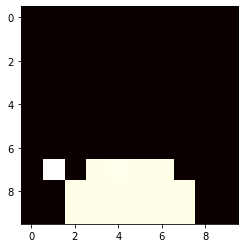

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,x,a
E,a,c,d,2,a,b,b,2,x,a
F,2,2,a,c,a,2,c,c,x,2
G,a,b,a,b,2,a,a,d,2,a
H,c,2,d,.,.,.,.,a,2,a
I,2,a,.,.,.,.,.,.,a,2
J,a,a,.,.,.,.,.,.,a,b



Turno: 159 Puntos:691
Almacen: [.] Actual: [a]


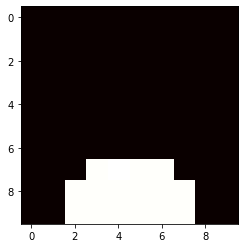

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,x,a
E,a,c,d,2,a,b,b,2,x,a
F,2,2,a,c,a,2,c,c,x,2
G,a,b,a,b,2,a,a,d,2,a
H,c,2,d,.,a,.,.,a,2,a
I,2,a,.,.,.,.,.,.,a,2
J,a,a,.,.,.,.,.,.,a,b



Turno: 160 Puntos:692
Almacen: [.] Actual: [a]


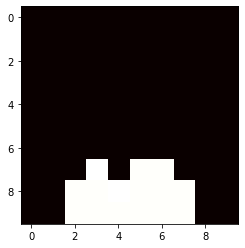

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,x,a
E,a,c,d,2,a,b,b,2,x,a
F,2,2,a,c,a,2,c,c,x,2
G,a,b,a,b,2,a,a,d,2,a
H,c,2,d,a,a,.,.,a,2,a
I,2,a,.,.,.,.,.,.,a,2
J,a,a,.,.,.,.,.,.,a,b



Turno: 161 Puntos:693
Almacen: [.] Actual: [a]


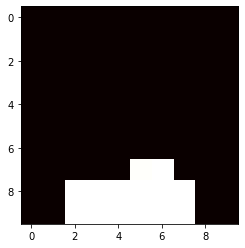

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,x,a
E,a,c,d,2,a,b,b,2,x,a
F,2,2,a,c,a,2,c,c,x,2
G,a,b,a,b,2,a,a,d,2,a
H,c,2,d,.,.,.,.,a,2,a
I,2,a,.,b,.,.,.,.,a,2
J,a,a,.,.,.,.,.,.,a,b



Turno: 162 Puntos:696
Almacen: [.] Actual: [a]


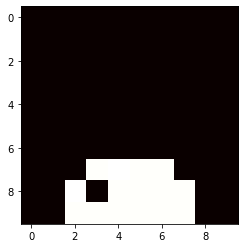

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,x,a
E,a,c,d,2,a,b,b,2,x,a
F,2,2,a,c,a,2,c,c,x,2
G,a,b,a,b,2,a,a,d,2,a
H,c,2,d,.,a,.,.,a,2,a
I,2,a,.,b,.,.,.,.,a,2
J,a,a,.,.,.,.,.,.,a,b



Turno: 163 Puntos:697
Almacen: [.] Actual: [a]


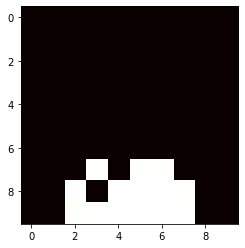

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,x,a
E,a,c,d,2,a,b,b,2,x,a
F,2,2,a,c,a,2,c,c,x,2
G,a,b,a,b,2,a,a,d,2,a
H,c,2,d,a,a,.,.,a,2,a
I,2,a,.,b,.,.,.,.,a,2
J,a,a,.,.,.,.,.,.,a,b



Turno: 164 Puntos:698
Almacen: [.] Actual: [a]


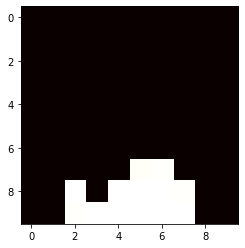

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,x,a
E,a,c,d,2,a,b,b,2,x,a
F,2,2,a,c,a,2,c,c,x,2
G,a,b,a,b,2,a,a,d,2,a
H,c,2,d,.,.,.,.,a,2,a
I,2,a,.,b,b,.,.,.,a,2
J,a,a,.,.,.,.,.,.,a,b



Turno: 165 Puntos:701
Almacen: [.] Actual: [w]


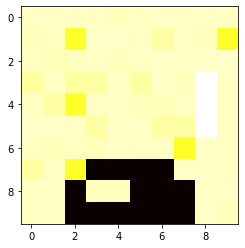

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,.,a
E,a,c,d,2,a,b,b,2,x,a
F,2,2,a,c,a,2,c,c,x,2
G,a,b,a,b,2,a,a,d,2,a
H,c,2,d,.,.,.,.,a,2,a
I,2,a,.,b,b,.,.,.,a,2
J,a,a,.,.,.,.,.,.,a,b



Turno: 166 Puntos:751
Almacen: [.] Actual: [a]


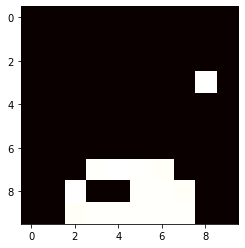

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,.,a
E,a,c,d,2,a,b,b,2,x,a
F,2,2,a,c,a,2,c,c,x,2
G,a,b,a,b,2,a,a,d,2,a
H,c,2,d,.,.,.,.,a,2,a
I,2,.,c,.,.,.,.,.,a,2
J,.,.,.,.,.,.,.,.,a,b



Turno: 167 Puntos:763
Almacen: [.] Actual: [a]


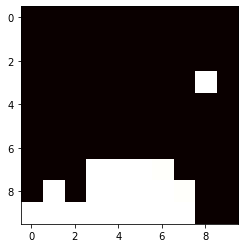

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,.
E,a,c,d,2,a,b,b,2,x,.
F,2,2,a,c,a,2,c,c,x,2
G,a,b,a,b,2,a,a,d,2,a
H,c,2,d,.,.,.,.,a,2,a
I,2,.,c,.,.,.,.,.,a,2
J,.,.,.,.,.,.,.,.,a,b



Turno: 168 Puntos:766
Almacen: [.] Actual: [a]


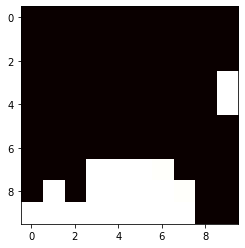

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,x,.
F,2,2,a,c,a,2,c,c,x,2
G,a,b,a,b,2,a,a,d,2,a
H,c,2,d,.,.,.,.,a,2,a
I,2,.,c,.,.,.,.,.,a,2
J,.,.,.,.,.,.,.,.,a,b



Turno: 169 Puntos:767
Almacen: [.] Actual: [1]


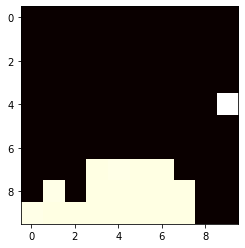

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,x,2
F,2,2,a,c,a,2,c,c,x,2
G,a,b,a,b,2,a,a,d,2,a
H,c,2,d,.,.,.,.,a,2,a
I,2,.,c,.,.,.,.,.,a,2
J,.,.,.,.,.,.,.,.,a,b



Turno: 170 Puntos:762
Almacen: [.] Actual: [a]


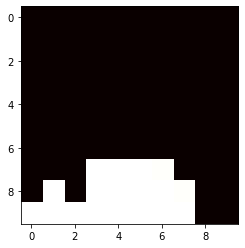

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,x,2
F,2,2,a,c,a,2,c,c,x,2
G,a,b,a,b,2,a,a,d,2,a
H,c,2,d,.,a,.,.,a,2,a
I,2,.,c,.,.,.,.,.,a,2
J,.,.,.,.,.,.,.,.,a,b



Turno: 171 Puntos:763
Almacen: [.] Actual: [a]


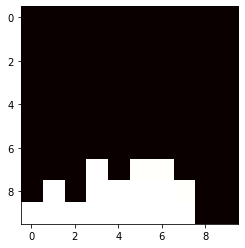

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,x,2
F,2,2,a,c,a,2,c,c,x,2
G,a,b,a,b,2,a,a,d,2,a
H,c,2,d,a,a,.,.,a,2,a
I,2,.,c,.,.,.,.,.,a,2
J,.,.,.,.,.,.,.,.,a,b



Turno: 172 Puntos:764
Almacen: [.] Actual: [a]


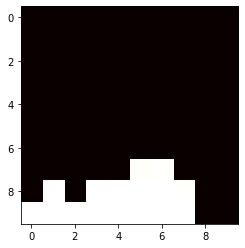

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,x,2
F,2,2,a,c,a,2,c,c,x,2
G,a,b,a,b,2,a,a,d,2,a
H,c,2,d,a,a,.,.,a,2,a
I,2,a,c,.,.,.,.,.,a,2
J,.,.,.,.,.,.,.,.,a,b



Turno: 173 Puntos:765
Almacen: [.] Actual: [w]


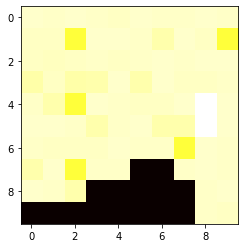

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,.,2
F,2,2,a,c,a,2,c,c,x,2
G,a,b,a,b,2,a,a,d,2,a
H,c,2,d,a,a,.,.,a,2,a
I,2,a,c,.,.,.,.,.,a,2
J,.,.,.,.,.,.,.,.,a,b



Turno: 174 Puntos:815
Almacen: [.] Actual: [a]


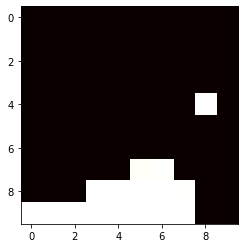

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,a,2
F,2,2,a,c,a,2,c,c,x,2
G,a,b,a,b,2,a,a,d,2,a
H,c,2,d,a,a,.,.,a,2,a
I,2,a,c,.,.,.,.,.,a,2
J,.,.,.,.,.,.,.,.,a,b



Turno: 175 Puntos:816
Almacen: [.] Actual: [b]


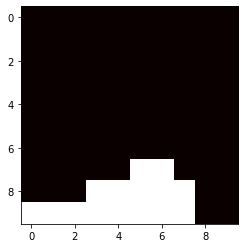

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,a,2
F,2,2,a,c,a,2,c,c,x,2
G,a,b,a,b,2,a,a,d,2,a
H,c,2,d,a,a,.,.,a,2,a
I,2,a,c,.,.,.,.,.,a,2
J,b,.,.,.,.,.,.,.,a,b



Turno: 176 Puntos:821
Almacen: [.] Actual: [a]


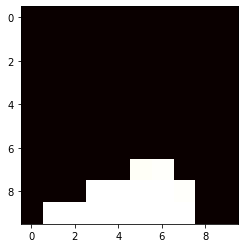

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,a,2
F,2,2,a,c,a,2,c,c,x,2
G,a,b,a,b,2,a,a,d,2,a
H,c,2,d,a,a,.,.,a,2,a
I,2,a,c,.,.,.,.,.,a,2
J,b,a,.,.,.,.,.,.,a,b



Turno: 177 Puntos:822
Almacen: [.] Actual: [a]


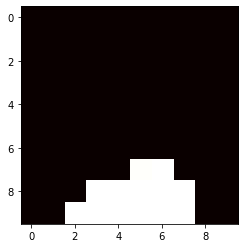

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,a,2
F,2,2,a,c,a,2,c,c,x,2
G,a,b,a,b,2,a,a,d,2,a
H,c,2,d,.,.,.,.,a,2,a
I,2,a,c,b,.,.,.,.,a,2
J,b,a,.,.,.,.,.,.,a,b



Turno: 178 Puntos:825
Almacen: [.] Actual: [a]


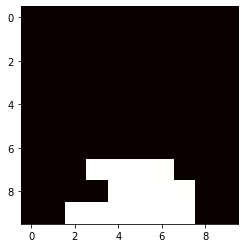

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,a,2
F,2,2,a,c,a,2,c,c,x,2
G,a,b,a,b,2,a,a,d,2,a
H,c,2,d,.,a,.,.,a,2,a
I,2,a,c,b,.,.,.,.,a,2
J,b,a,.,.,.,.,.,.,a,b



Turno: 179 Puntos:826
Almacen: [.] Actual: [a]


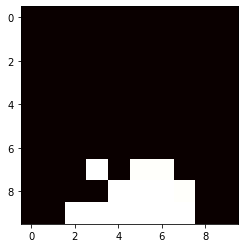

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,a,2
F,2,2,a,c,a,2,c,c,x,2
G,a,b,a,b,2,a,a,d,2,a
H,c,2,d,a,a,.,.,a,2,a
I,2,a,c,b,.,.,.,.,a,2
J,b,a,.,.,.,.,.,.,a,b



Turno: 180 Puntos:827
Almacen: [.] Actual: [1]


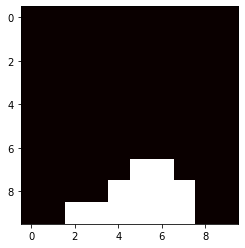

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,a,2
F,2,2,a,c,a,2,c,c,x,2
G,a,b,a,b,2,a,a,d,2,a
H,c,2,d,a,a,1,.,a,2,a
I,2,a,c,b,.,.,.,.,a,2
J,b,a,.,.,.,.,.,.,a,b



Turno: 181 Puntos:802
Almacen: [.] Actual: [a]


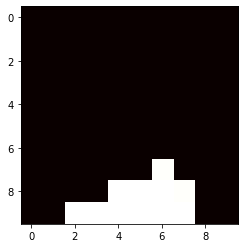

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,a,2
F,2,2,a,c,a,2,c,c,x,2
G,a,b,a,b,2,a,a,d,2,a
H,c,2,d,.,.,.,1,a,2,a
I,2,a,c,b,b,.,.,.,a,2
J,b,a,.,.,.,.,.,.,a,b



Turno: 182 Puntos:805
Almacen: [.] Actual: [a]


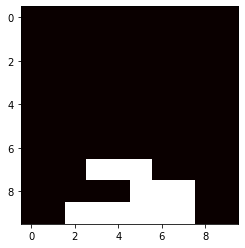

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,a,2
F,2,2,a,c,a,2,c,c,x,2
G,a,b,a,b,2,a,a,d,2,a
H,c,2,d,.,a,.,.,a,2,a
I,2,a,c,b,b,.,1,.,a,2
J,b,a,.,.,.,.,.,.,a,b



Turno: 183 Puntos:806
Almacen: [.] Actual: [a]


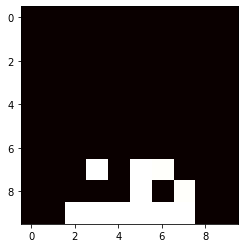

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,a,2
F,2,2,a,c,a,2,c,c,x,2
G,a,b,a,b,2,a,a,d,2,a
H,c,2,d,a,a,.,1,a,2,a
I,2,a,c,b,b,.,.,.,a,2
J,b,a,.,.,.,.,.,.,a,b



Turno: 184 Puntos:807
Almacen: [.] Actual: [b]


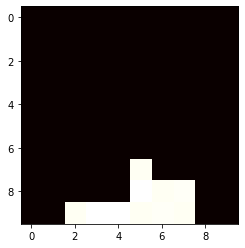

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,a,2
F,2,2,a,c,a,2,c,c,x,2
G,a,b,a,b,2,a,a,d,2,a
H,c,2,d,a,a,.,.,a,2,a
I,2,a,c,.,.,c,1,.,a,2
J,b,a,.,.,.,.,.,.,a,b



Turno: 185 Puntos:822
Almacen: [.] Actual: [a]


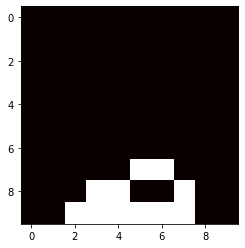

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,a,2
F,2,2,a,c,a,2,c,c,x,2
G,a,b,a,b,2,a,a,d,2,a
H,c,2,d,.,.,.,1,a,2,a
I,2,a,c,b,.,c,.,.,a,2
J,b,a,.,.,.,.,.,.,a,b



Turno: 186 Puntos:825
Almacen: [.] Actual: [a]


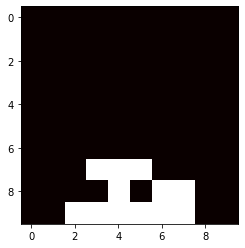

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,a,2
F,2,2,a,c,a,2,c,c,x,2
G,a,b,a,b,2,a,a,d,2,a
H,c,2,d,.,a,.,.,a,2,a
I,2,a,c,b,.,c,1,.,a,2
J,b,a,.,.,.,.,.,.,a,b



Turno: 187 Puntos:826
Almacen: [.] Actual: [1]


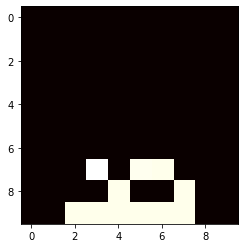

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,a,2
F,2,2,a,c,a,2,c,c,x,2
G,a,b,a,b,2,a,a,d,2,a
H,c,2,d,2,a,.,1,a,2,a
I,2,a,c,b,.,c,.,.,a,2
J,b,a,.,.,.,.,.,.,a,b



Turno: 188 Puntos:821
Almacen: [.] Actual: [a]


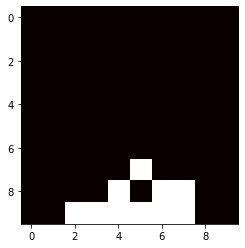

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,a,2
F,2,2,a,c,a,2,c,c,x,2
G,a,b,a,b,2,a,a,d,2,a
H,c,2,d,2,a,.,.,a,2,a
I,2,a,c,b,a,c,1,.,a,2
J,b,a,.,.,.,.,.,.,a,b



Turno: 189 Puntos:822
Almacen: [.] Actual: [a]


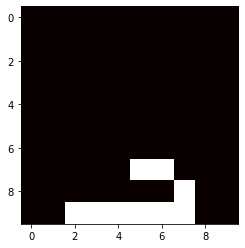

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,a,2
F,2,2,a,c,a,2,c,c,x,2
G,a,b,a,b,2,a,a,d,2,a
H,c,2,d,2,a,.,1,a,2,a
I,2,.,c,b,a,c,.,.,a,2
J,b,.,b,.,.,.,.,.,a,b



Turno: 190 Puntos:825
Almacen: [.] Actual: [a]


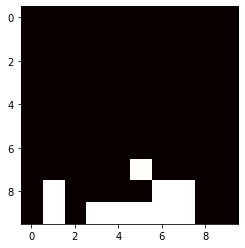

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,a,2
F,2,2,a,c,a,2,c,c,x,2
G,a,b,a,b,2,a,a,d,2,a
H,c,2,d,2,a,.,.,a,2,a
I,2,a,c,b,a,c,1,.,a,2
J,b,.,b,.,.,.,.,.,a,b



Turno: 191 Puntos:826
Almacen: [.] Actual: [a]


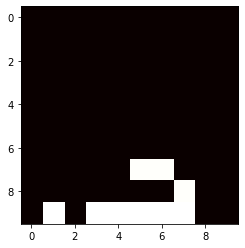

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,a,2
F,2,2,a,c,a,2,c,c,x,2
G,a,b,a,b,2,a,a,d,2,a
H,c,2,d,2,a,.,1,a,2,a
I,2,a,c,b,a,c,x,.,a,2
J,b,a,b,.,.,.,.,.,a,b



Turno: 192 Puntos:777
Almacen: [.] Actual: [a]


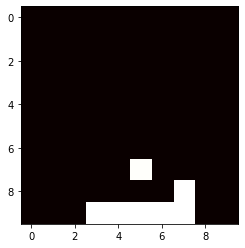

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,a,2
F,2,2,a,c,a,2,c,c,x,2
G,a,b,a,b,2,a,a,d,2,a
H,c,2,d,2,a,.,x,1,2,a
I,2,a,c,b,a,c,x,b,.,2
J,b,a,b,.,.,.,.,.,.,b



Turno: 193 Puntos:729
Almacen: [.] Actual: [a]


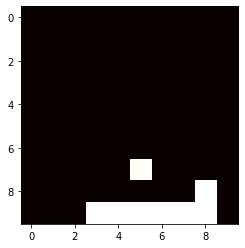

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,a,2
F,2,2,a,c,a,2,c,c,x,2
G,a,b,a,b,2,a,a,d,3,a
H,c,2,d,2,a,.,x,.,.,a
I,2,a,c,b,a,c,x,b,a,2
J,b,a,b,.,.,.,.,.,.,b



Turno: 194 Puntos:815
Almacen: [.] Actual: [a]


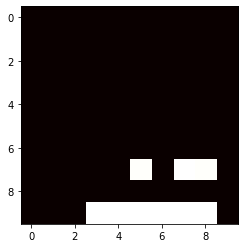

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,a,2
F,2,2,a,c,a,2,c,c,x,2
G,a,b,a,b,2,a,a,d,3,a
H,c,2,d,2,a,.,x,.,.,a
I,2,a,c,b,a,c,x,b,a,2
J,b,a,b,.,.,.,.,.,a,b



Turno: 195 Puntos:816
Almacen: [.] Actual: [a]


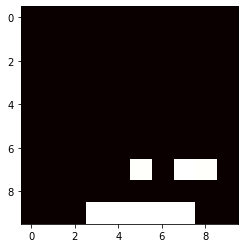

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,a,2
F,2,2,a,c,a,2,c,c,x,2
G,a,b,a,b,2,a,a,d,3,a
H,c,2,d,2,a,.,x,.,.,a
I,2,a,c,b,a,c,x,b,.,2
J,b,a,b,.,.,.,.,b,.,b



Turno: 196 Puntos:819
Almacen: [.] Actual: [w]


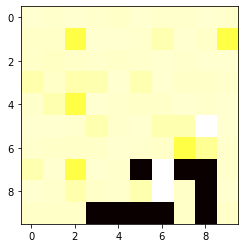

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,a,2
F,2,2,a,c,a,2,c,c,.,2
G,a,b,a,b,2,a,a,d,3,a
H,c,2,d,2,a,.,x,.,.,a
I,2,a,c,b,a,c,x,b,.,2
J,b,a,b,.,.,.,.,b,.,b



Turno: 197 Puntos:869
Almacen: [.] Actual: [a]


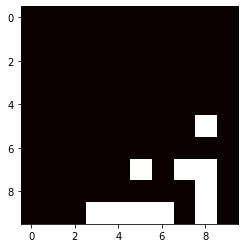

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,a,2
F,2,2,a,c,a,2,c,c,a,2
G,a,b,a,b,2,a,a,d,3,a
H,c,2,d,2,a,.,x,.,.,a
I,2,a,c,b,a,c,x,b,.,2
J,b,a,b,.,.,.,.,b,.,b



Turno: 198 Puntos:870
Almacen: [.] Actual: [a]


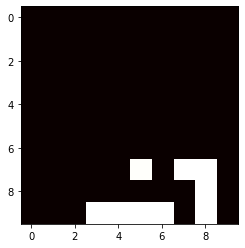

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,a,2
F,2,2,a,c,a,2,c,c,a,2
G,a,b,a,b,2,a,a,d,3,a
H,c,2,d,2,a,.,x,.,.,a
I,2,a,c,b,a,c,x,b,a,2
J,b,a,b,.,.,.,.,b,.,b



Turno: 199 Puntos:871
Almacen: [.] Actual: [a]


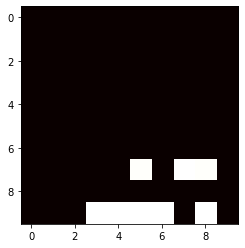

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,a,2
F,2,2,a,c,a,2,c,c,a,2
G,a,b,a,b,2,a,a,d,3,a
H,c,2,d,2,a,.,x,.,.,a
I,2,a,c,b,a,c,x,b,a,2
J,b,a,b,.,.,.,.,b,a,b



Turno: 200 Puntos:872
Almacen: [.] Actual: [a]


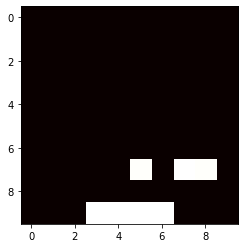

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,a,2
F,2,2,a,c,a,2,c,c,a,2
G,a,b,a,b,2,a,a,d,3,a
H,c,2,d,2,a,.,x,a,.,a
I,2,a,c,b,a,c,x,b,a,2
J,b,a,b,.,.,.,.,b,a,b



Turno: 201 Puntos:873
Almacen: [.] Actual: [a]


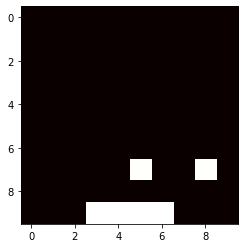

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,a,2
F,2,2,a,c,a,2,c,c,a,2
G,a,b,a,b,2,a,a,d,3,a
H,c,2,d,2,a,.,x,a,.,a
I,2,a,c,b,a,c,x,b,a,2
J,b,a,b,a,.,.,.,b,a,b



Turno: 202 Puntos:874
Almacen: [.] Actual: [1]


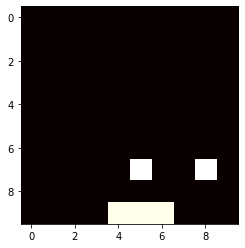

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,a,2
F,2,2,a,c,a,2,c,c,a,2
G,a,b,a,b,2,a,a,d,3,a
H,c,2,d,2,a,2,x,a,.,a
I,2,a,c,b,a,c,x,b,a,2
J,b,a,b,a,.,.,.,b,a,b



Turno: 203 Puntos:869
Almacen: [.] Actual: [a]


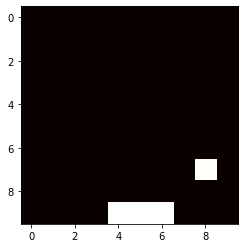

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,a,2
F,2,2,a,c,a,2,c,c,a,2
G,a,b,a,b,2,a,a,d,3,a
H,c,2,d,2,a,2,x,a,.,a
I,2,a,c,b,a,c,x,b,a,2
J,b,a,b,a,.,a,.,b,a,b



Turno: 204 Puntos:870
Almacen: [.] Actual: [a]


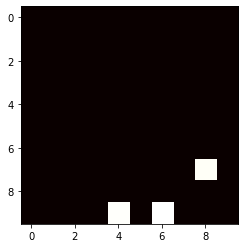

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,a,2
F,2,2,a,c,a,2,c,c,a,2
G,a,b,a,b,2,a,a,d,3,a
H,c,2,d,2,a,2,x,a,.,a
I,2,a,c,b,a,c,x,b,a,2
J,b,a,b,a,.,a,a,b,a,b



Turno: 205 Puntos:871
Almacen: [.] Actual: [a]


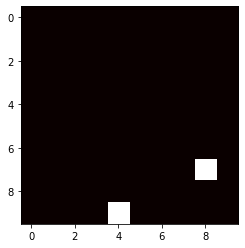

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,a,2
F,2,2,a,c,a,2,c,c,a,2
G,a,b,a,b,2,a,a,d,3,.
H,c,2,d,2,a,2,x,.,b,.
I,2,a,c,b,a,c,x,b,.,2
J,b,a,b,a,.,a,a,b,.,b



Turno: 206 Puntos:871
Almacen: [.] Actual: [a]


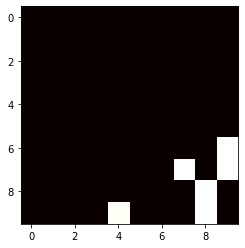

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,a,2
F,2,2,a,c,a,2,c,c,a,2
G,a,b,a,b,2,a,a,d,3,a
H,c,2,d,2,a,2,x,.,b,.
I,2,a,c,b,a,c,x,b,.,2
J,b,a,b,a,.,a,a,b,.,b



Turno: 207 Puntos:872
Almacen: [.] Actual: [a]


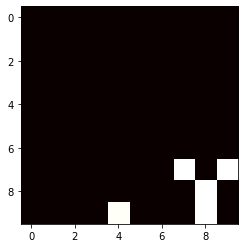

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,a,2
F,2,2,a,c,a,2,c,c,a,2
G,a,b,a,b,2,a,a,d,3,a
H,c,2,d,2,a,2,x,.,b,a
I,2,a,c,b,a,c,x,b,.,2
J,b,a,b,a,.,a,a,b,.,b



Turno: 208 Puntos:873
Almacen: [.] Actual: [a]


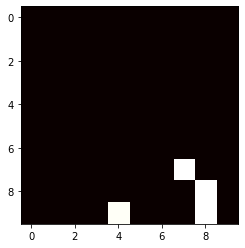

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,a,2
F,2,2,a,c,a,2,c,c,a,2
G,a,b,a,b,2,a,a,d,3,a
H,c,2,d,2,a,2,x,.,b,a
I,2,a,c,b,a,c,x,b,a,2
J,b,a,b,a,.,a,a,b,.,b



Turno: 209 Puntos:874
Almacen: [.] Actual: [a]


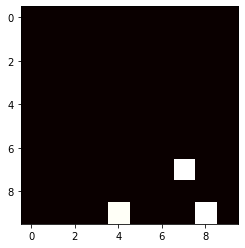

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,a,2
F,2,2,a,c,a,2,c,c,a,2
G,a,b,a,b,2,a,a,d,3,a
H,c,2,d,2,a,2,x,.,b,a
I,2,a,c,b,a,c,x,b,a,2
J,b,a,b,a,.,a,a,b,a,b



Turno: 210 Puntos:875
Almacen: [.] Actual: [a]


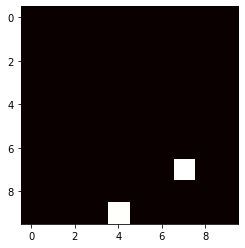

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,a,2
F,2,2,a,c,a,2,c,c,a,2
G,a,b,a,b,2,a,a,d,3,a
H,c,2,d,2,a,2,x,a,b,a
I,2,a,c,b,a,c,x,b,a,2
J,b,a,b,a,.,a,a,b,a,b



Turno: 211 Puntos:876
Almacen: [.] Actual: [a]


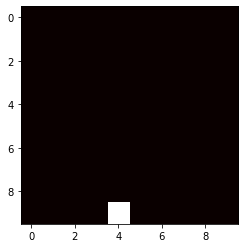

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,a,2
F,2,2,a,c,a,2,c,c,a,2
G,a,b,a,b,2,a,a,d,3,a
H,c,2,d,2,.,2,x,a,b,a
I,2,a,c,b,.,c,x,b,a,2
J,b,a,b,.,b,.,.,b,a,b



Turno: 212 Puntos:876
Almacen: [.] Actual: [a]


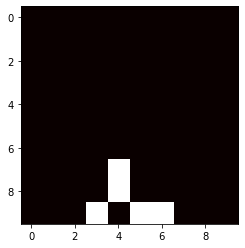

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,a,2
F,2,2,a,c,a,2,c,c,a,2
G,a,b,a,b,2,a,a,d,3,a
H,c,2,d,2,a,2,x,a,b,a
I,2,a,c,b,.,c,x,b,a,2
J,b,a,b,.,b,.,.,b,a,b



Turno: 213 Puntos:877
Almacen: [.] Actual: [a]


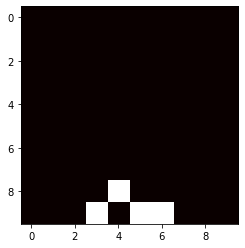

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,a,2
F,2,2,a,c,a,2,c,c,a,2
G,a,b,a,b,2,a,a,d,3,a
H,c,2,d,2,a,2,x,a,b,a
I,2,a,c,b,a,c,x,b,a,2
J,b,a,b,.,b,.,.,b,a,b



Turno: 214 Puntos:878
Almacen: [.] Actual: [b]


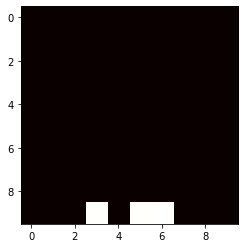

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,a,2
F,2,2,a,c,a,2,c,c,a,2
G,a,b,a,b,2,a,a,d,3,a
H,c,2,d,2,a,2,x,a,b,a
I,2,a,c,b,a,c,x,.,a,2
J,b,a,b,.,b,.,c,.,a,b



Turno: 215 Puntos:893
Almacen: [.] Actual: [a]


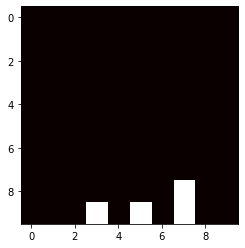

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,a,2
F,2,2,a,c,a,2,c,c,a,2
G,a,b,a,b,2,a,a,d,3,a
H,c,2,d,2,a,2,x,a,b,a
I,2,a,c,b,a,c,x,.,a,2
J,b,a,b,a,b,.,c,.,a,b



Turno: 216 Puntos:894
Almacen: [.] Actual: [a]


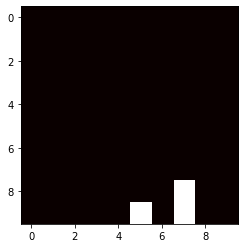

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,a,2
F,2,2,a,c,a,2,c,c,a,2
G,a,b,a,b,2,a,a,d,3,a
H,c,2,d,2,a,2,x,a,b,a
I,2,a,c,b,a,c,x,.,a,2
J,b,a,b,a,b,a,c,.,a,b



Turno: 217 Puntos:895
Almacen: [.] Actual: [a]


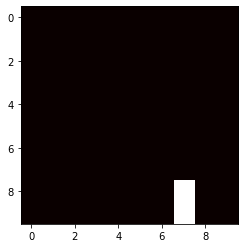

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,a,2
F,2,2,a,c,a,2,c,c,a,2
G,a,b,a,b,2,a,a,d,3,a
H,c,2,d,2,a,2,x,a,b,a
I,2,a,c,b,a,c,x,.,.,2
J,b,a,b,a,b,a,c,b,.,b



Turno: 218 Puntos:898
Almacen: [.] Actual: [1]


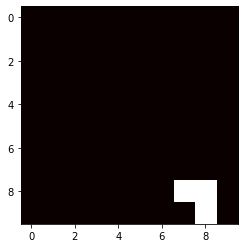

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,a,2
F,2,2,a,c,a,2,c,c,a,2
G,a,b,a,b,2,a,a,d,3,a
H,c,2,d,2,a,2,x,a,b,a
I,2,a,c,b,a,c,x,.,1,2
J,b,a,b,a,b,a,c,b,.,b



Turno: 219 Puntos:873
Almacen: [.] Actual: [a]


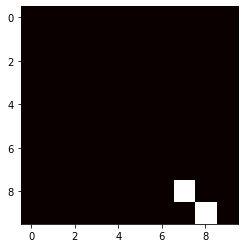

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,a,2
F,2,2,a,c,a,2,c,c,a,2
G,a,b,a,b,2,a,a,d,3,a
H,c,2,d,2,a,2,x,a,b,a
I,2,a,c,b,a,c,x,a,.,2
J,b,a,b,a,b,a,c,b,1,b



Turno: 220 Puntos:874
Almacen: [.] Actual: [a]


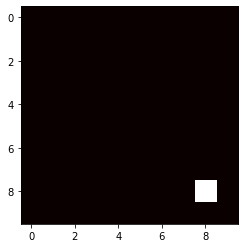

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,a,2
F,2,2,a,c,a,2,c,c,a,2
G,a,b,a,b,2,a,a,d,3,a
H,c,2,d,2,a,2,x,.,b,a
I,2,a,c,b,a,c,x,.,b,2
J,b,a,b,a,b,a,c,b,2,b



Turno: 221 Puntos:897
Almacen: [.] Actual: [1]


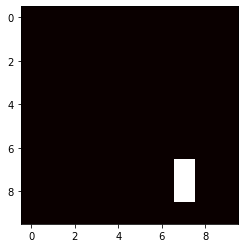

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,a,2
F,2,2,a,c,a,2,c,c,a,2
G,a,b,a,b,2,a,a,d,3,a
H,c,2,d,2,a,2,x,1,b,a
I,2,a,c,b,a,c,x,.,b,2
J,b,a,b,a,b,a,c,b,2,b



Turno: 222 Puntos:872
Almacen: [.] Actual: [b]


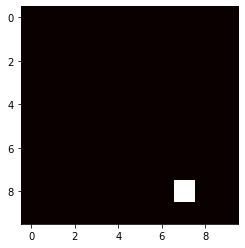

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,a,2
F,2,2,a,c,a,2,c,c,a,2
G,a,b,a,b,2,a,a,d,3,a
H,c,2,d,2,a,2,x,.,1,a
I,2,a,c,b,a,c,x,c,.,2
J,b,a,b,a,b,a,c,.,2,b



Turno: 223 Puntos:882
Almacen: [.] Actual: [a]


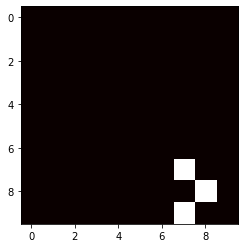

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,a,2
F,2,2,a,c,a,2,c,c,a,2
G,a,b,a,b,2,a,a,d,3,a
H,c,2,d,2,a,2,x,1,.,a
I,2,a,c,b,a,c,x,c,a,2
J,b,a,b,a,b,a,c,.,2,b



Turno: 224 Puntos:883
Almacen: [.] Actual: [a]


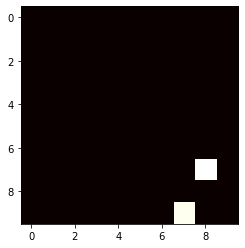

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,a,2
F,2,2,a,c,a,2,c,c,a,2
G,a,b,a,b,2,a,a,d,3,.
H,c,2,d,2,a,2,x,2,b,.
I,2,a,c,b,a,c,x,c,.,2
J,b,a,b,a,b,a,c,.,2,b



Turno: 225 Puntos:905
Almacen: [.] Actual: [a]


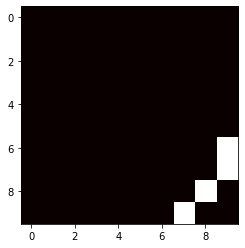

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,a,2
F,2,2,a,c,a,2,c,c,a,2
G,a,b,a,b,2,a,a,d,3,a
H,c,2,d,2,a,2,x,2,b,.
I,2,a,c,b,a,c,x,c,.,2
J,b,a,b,a,b,a,c,.,2,b



Turno: 226 Puntos:906
Almacen: [.] Actual: [1]


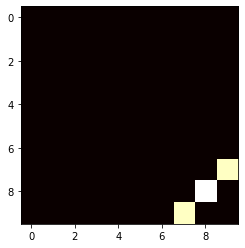

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,a,2
F,2,2,a,c,a,2,c,c,a,2
G,a,b,a,b,2,a,a,d,3,a
H,c,2,d,2,a,2,x,2,b,.
I,2,a,c,b,a,c,x,c,.,3
J,b,a,b,a,b,a,c,.,.,b



Turno: 227 Puntos:966
Almacen: [.] Actual: [a]


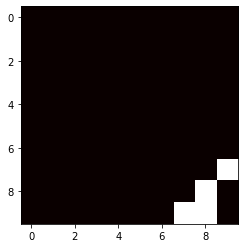

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,a,2
F,2,2,a,c,a,2,c,c,a,2
G,a,b,a,b,2,a,a,d,3,a
H,c,2,d,2,a,2,x,2,b,a
I,2,a,c,b,a,c,x,c,.,3
J,b,a,b,a,b,a,c,.,.,b



Turno: 228 Puntos:967
Almacen: [.] Actual: [b]


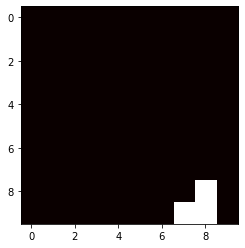

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,a,2
F,2,2,a,c,a,2,c,c,a,2
G,a,b,a,b,2,a,a,d,3,a
H,c,2,d,2,a,2,x,2,b,a
I,2,a,c,b,a,c,x,c,b,3
J,b,a,b,a,b,a,c,.,.,b



Turno: 229 Puntos:972
Almacen: [.] Actual: [a]


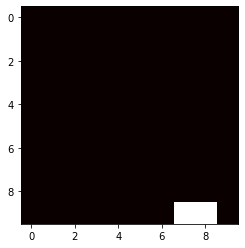

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,a,2
F,2,2,a,c,a,2,c,c,a,2
G,a,b,a,b,2,a,a,d,3,a
H,c,2,d,2,a,2,x,2,b,a
I,2,a,c,b,a,c,x,c,b,3
J,b,a,b,a,b,a,c,a,.,b



Turno: 230 Puntos:973
Almacen: [.] Actual: [a]


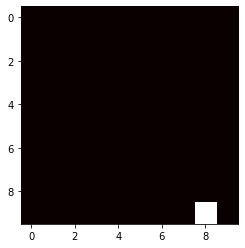

,0,1,2,3,4,5,6,7,8,9
A,2,a,2,a,b,2,a,a,2,a
B,b,a,d,2,2,a,c,2,b,d
C,a,b,a,a,b,a,2,a,2,2
D,c,a,c,c,2,c,2,b,b,a
E,a,c,d,2,a,b,b,2,a,2
F,2,2,a,c,a,2,c,c,a,2
G,a,b,a,b,2,a,a,d,3,a
H,c,2,d,2,a,2,x,2,b,a
I,2,a,c,b,a,c,x,c,b,3
J,b,a,b,a,b,a,c,a,a,b



Turno: 231 Puntos:974
Almacen: [.] Actual: [a]
Partida terminada, GG:👏


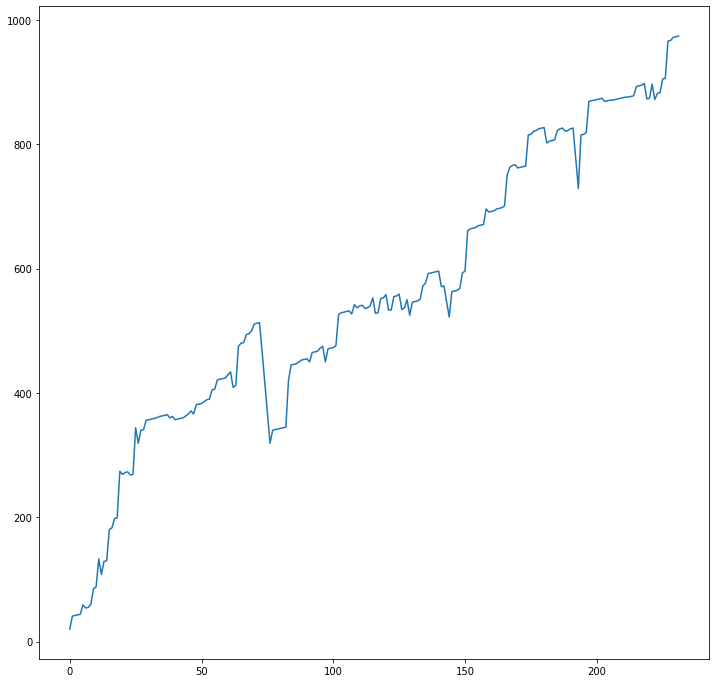

In [6]:
import random
import math
import copy
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt

class TrieNode:
    def __init__(self, inputChar):
        self.char = inputChar
        self.end = False
        self.children = {}
 
class Trie():
    def __init__(self, startingElements=None):
        self.root = TrieNode("")
        if startingElements!=None:
          for i in startingElements: self.insert(i)
    def insert(self, word):
        node = self.root
        for char in word:
            if char in node.children:
                node = node.children[char]
            else:
                new_node = TrieNode(char)
                node.children[char] = new_node
                node = new_node
        node.end = True      
    def searchAndSplit(self, x):
        node = self.root
        output = ["", ""]
        for char in x:
            if char in node.children:
                node = node.children[char]            
            else:
                return []        
            output[1 if node.end else 0] += node.char
        return output if node.end else []
    def toGraph(self):
      from pyvis.network import Network
      g = Network(directed =True)      
      g.show_buttons()

      nodeIndex = 1
      currentNode = 0
      q = [self.root]      
      g.add_node(currentNode, label="", color="red")
      tempLabels = {0:""}
      while q!=[]:
        n = q.pop(0)                     
        for i in n.children.values():
          tempLabels[nodeIndex] = tempLabels[currentNode]+i.char
          g.add_node(nodeIndex, label=tempLabels[currentNode]+i.char, color="#48e073" if i.end else "blue")
          g.add_edge(currentNode, nodeIndex)
          nodeIndex+=1
          q.append(i)
        currentNode+=1
      g.show('nx.html')

class MainGame:
  def __init__(self):
    #random.seed(368) #311
    self.objects = {".":[".",0],"a":["b",1],"b":["c",5],"c":["d",25],"d":["e",125],"e":["e",625],"1":["1",-25],"2":["3",-5],"3":["4",50],"4":["4",500],"x":["x",-50]}
    self.checkAndLoadFiles()    
    self.turn = 0
    self.score = []
    self.storage = "."
    self.bigFoots = [[(i,j), 0, False] for i in range(len(self.matrix)) for j in range(len(self.matrix[0])) if self.matrix[i][j]=="1"]
    self.updateActual()
    self.tr = Trie((''.join(chr(97+int(j)) for j in str(i))+str(k) for k in range(len(self.matrix[0])) for i in range(len(self.matrix))))
    self.tr.insert("exit")
    self.tr.insert("hint")
    self.tr.insert("*")
    self.tr.toGraph()

  def checkAndLoadFiles(self):
    try:
      with open("tablero.txt", "r") as f:
        self.matrix=[]        
        for i in f.readlines():
          self.matrix.append([])
          for j in i.replace("\n", ""):
            if not j in self.objects: raise
            self.matrix[-1].append(j)
    except:
      self.matrix = [random.sample(["."]*45+["a"]*18+["b"]*4+["c"]*3+["1"]*2, 10) for i in range(10)]
      print("Error al cargar el fichero tablero, usando tablero aleatorio...")      
    try:
      with open("secuencia.txt", "r") as f:
        self.seq=""
        for i in f.readline():
          if i not in self.objects and i != "w": raise
          self.seq += i
    except:
      self.seq = ""
      print("Error al cargar el fichero secuencia, usando secuencia aleatoria...")      

  def main(self):
    print("Que empiece el juego:\U0001F609")
    self.showGame()    
    while any("." in x for x in self.matrix):
      message = self.validarEntrada("hint")#self.validarEntrada(input("Mover a casilla: ").lower().replace(" ", ""))
      while not message[0]: message = self.validarEntrada(input("Jugada errónea\nMover a casilla: ").lower().replace(" ", ""))

      if "".join(message[1])=="exit": break
      if "".join(message[1])=="*": self.storage=self.actual; self.updateActual(); self.showGame(); continue;
      coordinates = (lambda l: (int("".join([str(ord(i)%97) for i in l[0]])), int(l[1])))(message[1]) if "".join(message[1])!="hint" else self.getHint()
      if not ((self.matrix[coordinates[0]][coordinates[1]]==".") ^ (self.actual=="w")): print("Jugada errónea"); continue;

      self.updateMatrix(coordinates)
      self.updateActual()
      self.turn+=1
      self.bigFoots = [[i[0], i[1]+1, i[2]] for i in self.bigFoots]
      
      self.showGame()
    print("Partida terminada, GG:\U0001F44F")
    fig = plt.figure(figsize=(12, 12))
    plt.plot(list(range(len(self.score))), self.score)
    plt.show()

  def getHint(self):
    prevObjs = sum(1 for a in self.matrix for b in a if b!=".")
    tempValues=[-math.inf, (0,0)]
    debugValues = [[0]*len(self.matrix[0]) for i in range(len(self.matrix))]
    for i in range(len(self.matrix)):
      for j in range(len(self.matrix[0])):
        if (self.matrix[i][j] == ".") ^ (self.actual=="w"): 
          newObj = copy.deepcopy(g)
          newObj.updateMatrix((i,j))
          newScore = sum(sum(self.objects[b][1] - (b == "." or 0) for b in a) for a in newObj.matrix) + (prevObjs - 3*newObj.minDistanceToElement((i,j), ["1", "2", newObj.matrix[i][j]]))
          if newScore>tempValues[0]: tempValues = [newScore, (i,j)]
          debugValues[i][j] = newScore
    plt.imshow(debugValues, cmap='hot', interpolation='nearest')
    plt.show()
    return tempValues[1]
  
  def minDistanceToElement(self, coordinates, elements):
    visited = set()
    q = [(coordinates, 0)]
    while q:
        n, distance = q.pop(0)
        if n in visited:
            continue
        visited.add(n)
        for i, j in ((n[0]-1, n[1]), (n[0]+1, n[1]), (n[0], n[1]-1), (n[0], n[1]+1)):
            if i < 0 or i >= len(self.matrix) or j < 0 or j >= len(self.matrix[0]):
                continue
            if self.matrix[i][j] in elements:
                return distance+1
            q.append(((i,j), distance+1))
    return 0   
  
  def updateActual(self):
    self.actual = random.choice(["a"]*30+["b"]*5+["c"]*1+["1"]*6+["w"]*1) if self.seq=="" else self.seq[self.turn%len(self.seq)]
  
  def updateMatrix(self, coordinates):
    if self.actual=="w": self.matrix[coordinates[0]][coordinates[1]] = "."; self.deleteBigFoot(coordinates); return;
    self.matrix[coordinates[0]][coordinates[1]] = self.actual
    if self.actual=="1": self.bigFoots.append([coordinates, 0, False]); self.updateBigFoots(); return;

    self.checkAndColapse(coordinates)
    self.updateBigFoots()

  def checkAndColapse(self, coordinates):
    g = (self.getGroup(coordinates), self.matrix[coordinates[0]][coordinates[1]])
    if g[1]=="2": coordinates = max(g[0], key=lambda x:[k for k in self.bigFoots if k[0]==x][0][1])
    while len(g[0])>2:
      for i in g[0]: 
        if self.matrix[i[0]][i[1]] == "2": self.deleteBigFoot(i);
        self.matrix[i[0]][i[1]] = "."
      self.matrix[coordinates[0]][coordinates[1]] = self.objects[g[1]][0]
      g = (self.getGroup(coordinates), self.matrix[coordinates[0]][coordinates[1]])
  
  def deleteBigFoot(self, coordinates):
    for i in range(len(self.bigFoots)):
      if self.bigFoots[i][0] == coordinates: del self.bigFoots[i]; break;

  def updateBigFoots(self):
    for i in enumerate(self.bigFoots):
      n = i[1][:]
      if not n[2] and n[1]>0:
        for j in (lambda l:[k for k in l if k[0]>=0 and k[1]>=0])(((n[0][0]-1, n[0][1]), (n[0][0], n[0][1]+1), (n[0][0]+1, n[0][1]), (n[0][0], n[0][1]-1))):
          try:
            if self.matrix[j[0]][j[1]]==".": self.matrix[j[0]][j[1]]="1"; self.matrix[n[0][0]][n[0][1]]="x" if n[1]>10 else "."; self.bigFoots[i[0]][0]=j[:]; break;
          except: pass

      if n[0]==self.bigFoots[i[0]][0]: 
        g = self.getGroup(n[0], True)
        if not "." in (self.matrix[k[0]][k[1]] for k in g):
          for j in g: self.matrix[j[0]][j[1]] = "2"; bfIndex = [k for k in range(len(self.bigFoots)) if self.bigFoots[k][0]==j][0]; self.bigFoots[bfIndex][2]=True;  
          self.checkAndColapse(n[0])

  def getGroup(self, coordinates, bigFootMode=False):    
    visited = set()
    output = [coordinates]
    q = [coordinates]
    while q!=[]:
      n = q.pop(0)
      visited.add(n)
      for i in (lambda l:[j for j in l if j[0]>=0 and j[1]>=0])([(n[0]-1, n[1]), (n[0], n[1]+1), (n[0]+1, n[1]), (n[0], n[1]-1)]):
        try:
          if (not i in visited) and (self.matrix[i[0]][i[1]]==self.matrix[coordinates[0]][coordinates[1]] or (bigFootMode and self.matrix[i[0]][i[1]]==".")): q.append(i); output.append(i);
        except:
          pass
    return output

  def validarEntrada(self, s):
    s = self.tr.searchAndSplit(s)
    return (True if s else False, s)

  def showGame(self):
    df = pd.DataFrame(self.matrix, columns=list(range(len(self.matrix[0]))), index=[''.join(chr(65+int(j)) for j in str(i)) for i in range(len(self.matrix))])
    display(HTML(df.to_html()))
    self.score.append(sum(self.objects[j][1] for i in self.matrix for j in i))
    print(f"\nTurno: {self.turn} Puntos:{self.score[-1]}\nAlmacen: [{self.storage}] Actual: [{self.actual}]")

if __name__=="__main__":
  g = MainGame()
  g.main()

**Bot Encoding**

In [97]:
import copy
copyObj = copy.copy(g)

In [98]:
copyObj.__dict__

{'objects': {'.': ['.', 0],
  'a': ['b', 1],
  'b': ['c', 5],
  'c': ['d', 25],
  'd': ['e', 125],
  'e': ['e', 625],
  '1': ['1', -25],
  '2': ['3', -5],
  '3': ['4', 50],
  '4': ['4', 500],
  'x': ['x', -50]},
 'matrix': [['b', 'a', 'a', '2', 'a', '2', 'a', 'a', '3', 'a'],
  ['2', 'a', '2', 'a', '2', 'a', '2', 'a', '2', 'a'],
  ['a', '2', 'a', 'c', 'a', 'b', 'a', 'c', 'a', 'b'],
  ['a', 'c', 'a', '3', 'a', '2', 'a', '2', 'a', 'b'],
  ['b', '2', 'c', '2', '2', 'c', '3', 'a', 'c', '2'],
  ['b', 'a', '2', 'a', 'b', 'a', 'c', 'a', '2', 'a'],
  ['a', 'b', '2', 'c', 'd', '2', 'a', '3', 'a', 'a'],
  ['a', 'b', 'd', 'a', 'a', 'c', 'a', 'd', 'a', '2'],
  ['d', '3', 'b', '2', 'c', 'x', 'b', '2', 'a', 'a'],
  ['a', 'b', 'a', 'a', 'c', '2', 'a', 'a', '2', 'a']],
 'seq': '',
 'turn': 227,
 'score': [-14,
  7,
  10,
  5,
  6,
  7,
  28,
  49,
  50,
  51,
  52,
  53,
  -44,
  -3,
  -2,
  -1,
  4,
  -1,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  20,
  15,
  28,
  23,
  24,
  27,
  28,
  43,
 

Que empiece el juego:😉


,0,1,2,3,4,5
A,a,.,a,2,b,.
B,.,1,.,a,3,.
C,.,.,a,.,c,c
D,a,.,.,a,.,c
E,a,.,a,a,1,.
F,.,a,a,c,.,b



Turno: 7 Puntos:116
Almacen: [.] Actual: [a]
Mover a casilla: a1


,0,1,2,3,4,5
A,.,b,.,2,b,.
B,.,.,1,a,3,.
C,.,.,a,.,c,c
D,a,.,.,a,1,c
E,a,.,a,a,.,.
F,.,a,a,c,.,b



Turno: 8 Puntos:119
Almacen: [.] Actual: [1]
Mover a casilla: a5


,0,1,2,3,4,5
A,.,b,1,2,b,1
B,.,.,.,a,3,.
C,.,.,a,.,c,c
D,a,.,.,a,.,c
E,a,.,a,a,1,.
F,.,a,a,c,.,b



Turno: 9 Puntos:94
Almacen: [.] Actual: [a]
Mover a casilla: exit
Partida terminada, GG:👏


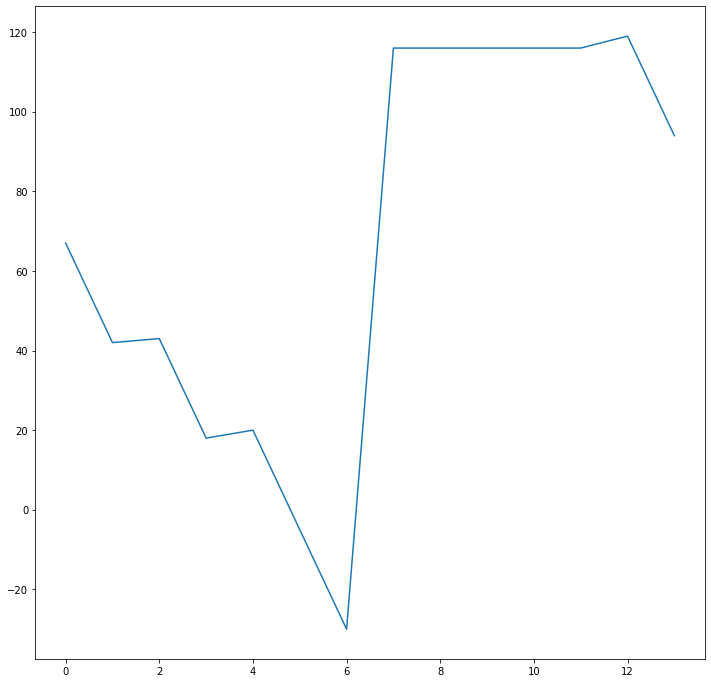

In [ ]:
copyObj.main()